# 1. Imports


1. Verify hd-bet works for PET images (try with and without skull)
     -> If not look at bet2
   
3. Try in Native space rather than MNI space
   
4. Try ADC if available

5. Expand Dataset
   
     -> Check unprocessed data, ADNI data (possibly ADNI for validation later)

6. Read literature and try different architectures
   
    -> Log metrics on test set after each experiment
        (SSIM, MSE, Inception score)

If use department GPU, make sure don't hog resources (esp if running overnight)

In [1]:
import matplotlib.pyplot as plt
import multiprocessing as mp
import nibabel as nib
import numpy as np
import os
import pandas as pd
import tempfile
from sklearn import metrics
import time
from time import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from monai.networks.nets import AHNet
from tqdm import tqdm
import monai
from monai.utils import progress_bar
from monai.config import print_config
from monai.data import Dataset, DataLoader, CacheDataset
from monai.transforms import (
    Activations,
    AsDiscrete,
    Compose,
    EnsureChannelFirstd,
    EnsureTyped,
    LoadImaged,
    MapTransform,
    Orientationd,
    RandRicianNoised,
    RandRotated,
    RandFlipd,
    Resized,
    Rotate90d,
    ScaleIntensityd,
    DeleteItemsd,
    NormalizeIntensityd
)
from monai.losses.ssim_loss import SSIMLoss
import statistics

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2,3,5"

In [3]:
%store -r dictionary_train
%store -r dictionary_valid
%store -r dictionary_test

In [4]:
# global variables
image_size = (128,128,64)

# 2. MONAI Dataloader

In [5]:
#To turn 4D images to 3D (from Ashley's classifier)
class MakeSingleVolumed(MapTransform):
    def __call__(self, data):
        for key in self.keys:
            num_volumes = data[key].shape[0]
            data["NumVolumes"] = num_volumes
            
            if num_volumes != 1:
                middle_volume = num_volumes // 2
                new_data = np.empty((1,image_size[0],image_size[1],image_size[2]))
                new_data[0,:,:,:] = data[key][middle_volume,:,:,:]
                # fill last slice with the value of num_volumes 
                new_data[0,:,:,-1] = np.zeros((data[key].shape[1],data[key].shape[2])) + num_volumes
                data[key] = torch.from_numpy(new_data)
            else:
                new_data = np.empty((1,image_size[0],image_size[1],image_size[2]))
                new_data[0,:,:,:] = data[key][0,:,:,:]
                # fill last slice with the value of num_volumes 
                new_data[0,:,:,-1] = np.zeros((data[key].shape[1],data[key].shape[2])) + num_volumes
                data[key] = torch.from_numpy(new_data)
                
        return data

#This uses the mask to scale the intensity of the image (not being used rn)
class ScaleImaged(MapTransform):
    def __call__(self, data):
            data[self.keys[0]] *= (0.4+data[self.keys[1]])

            return data

In [6]:
train_transforms = Compose(
    [
        LoadImaged(keys=["t1", "t1c", "t2", "flair", "pet"], reader=monai.data.ITKReader, image_only=True),
        EnsureChannelFirstd(keys=["t1", "t1c", "t2", "flair", "pet"]),
        Orientationd(keys=["t1", "t1c", "t2", "flair", "pet"], axcodes="RAS"),        
        EnsureTyped(keys=["t1", "t1c", "t2", "flair", "pet"]),
        Resized(keys=["t1", "t1c", "t2", "flair", "pet"], spatial_size=image_size),
        MakeSingleVolumed(keys=["t1", "t1c", "t2", "flair", "pet"]),
        Rotate90d(keys=["t1", "t1c", "t2", "flair", "pet"]),
        ScaleIntensityd(keys=["t1", "t1c", "t2", "flair", "pet"]),
        NormalizeIntensityd(keys=["t1", "t1c", "t2", "flair", "pet"]),
        RandFlipd(keys=["t1", "t1c", "t2", "flair", "pet"], prob=0.5, spatial_axis=1),
        RandRotated(keys=["t1", "t1c", "t2", "flair", "pet"], prob=0.6, range_z=0.3)
    ]
)

In [7]:
val_files = dictionary_train[:10]

check_ds = Dataset(data=val_files, transform=train_transforms)
check_DataLoader = DataLoader(check_ds, batch_size=1, shuffle=False)

It has been 17.99860119819641 seconds since the loop started


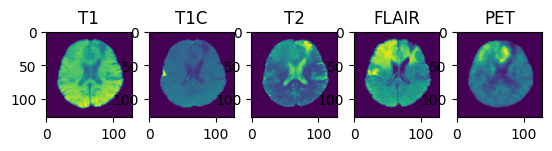

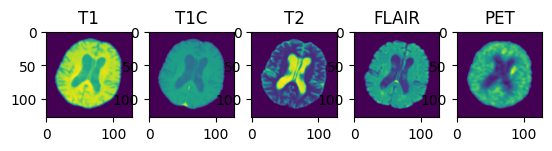

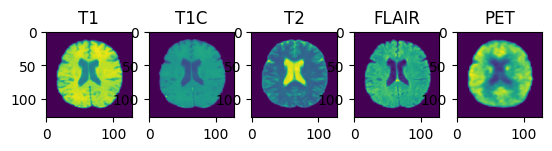

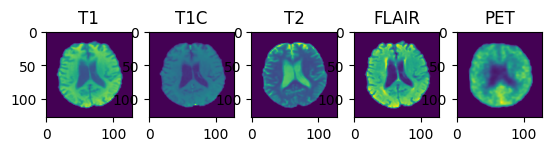

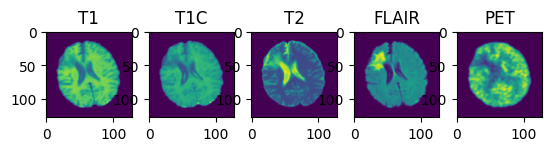

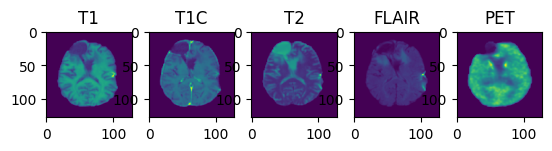

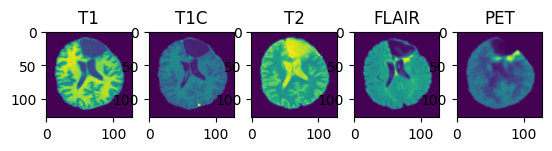

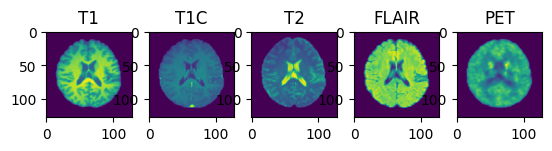

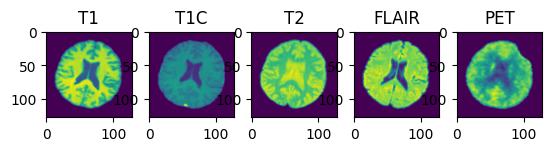

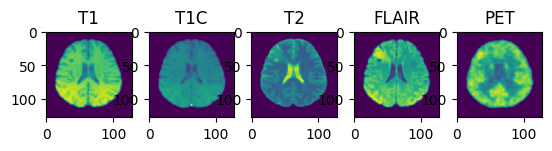

In [8]:
program_starts = time()
step = 1350
slice_index = 32
for item in check_DataLoader:
    image_datas = item["t1"][0, 0, :, :, slice_index], item["t1c"][0, 0, :, :, slice_index], item["t2"][0, 0, :, :, slice_index], item["flair"][0, 0, :, :, slice_index], item["pet"][0, 0, :, :, slice_index]
    
    f, axarr = plt.subplots(1, 5)
    
    axarr[0].imshow(image_datas[0])
    axarr[0].set_title("T1")
    axarr[1].imshow(image_datas[1])
    axarr[1].set_title("T1C")
    axarr[2].imshow(image_datas[2])
    axarr[2].set_title("T2")
    axarr[3].imshow(image_datas[3])
    axarr[3].set_title("FLAIR")
    axarr[4].imshow(image_datas[4])
    axarr[4].set_title("PET")
    
    step += 1
now = time()
print("It has been {0} seconds since the loop started".format(now - program_starts))

In [9]:
print(os.cpu_count())

train_ds = CacheDataset(data=dictionary_train, transform=train_transforms, cache_num=1024, num_workers=os.cpu_count())
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=os.cpu_count(), drop_last=False)

train_metric_ds = CacheDataset(data=dictionary_train[:10], transform=train_transforms, cache_num=1024, num_workers=os.cpu_count())
train_metric_loader = DataLoader(train_ds, batch_size=1, shuffle=False, num_workers=os.cpu_count())

valid_ds = CacheDataset(data=dictionary_valid, transform=train_transforms, cache_num=1024, num_workers=os.cpu_count())
valid_loader = DataLoader(valid_ds, batch_size=1, shuffle=False, num_workers=os.cpu_count())

test_ds = CacheDataset(data=dictionary_test, transform=train_transforms, cache_num=1024, num_workers=os.cpu_count())
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=os.cpu_count())

80


Loading dataset:   0%|                                  | 0/185 [00:00<?, ?it/s]

Loading dataset:   1%|▏                       | 1/185 [00:56<2:54:45, 56.99s/it]

Loading dataset:   1%|▎                       | 2/185 [00:58<1:14:54, 24.56s/it]

Loading dataset:   2%|▍                         | 3/185 [01:01<43:41, 14.40s/it]

Loading dataset:   2%|▌                         | 4/185 [01:02<27:59,  9.28s/it]

Loading dataset:   3%|▋                         | 5/185 [01:03<18:40,  6.22s/it]

Loading dataset:   3%|▊                         | 6/185 [01:09<18:24,  6.17s/it]

Loading dataset:   4%|▉                         | 7/185 [01:10<13:25,  4.52s/it]

Loading dataset:   4%|█                         | 8/185 [01:10<09:24,  3.19s/it]

Loading dataset:   6%|█▌                       | 12/185 [01:12<03:48,  1.32s/it]

Loading dataset:   7%|█▊                       | 13/185 [01:13<03:48,  1.33s/it]

Loading dataset:   8%|█▉                       | 14/185 [01:16<04:32,  1.60s/it]

Loading dataset:   8%|██                       | 15/185 [01:16<03:43,  1.32s/it]

Loading dataset:   9%|██▏                      | 16/185 [01:17<03:26,  1.22s/it]

Loading dataset:   9%|██▎                      | 17/185 [01:20<04:38,  1.66s/it]

Loading dataset:  10%|██▍                      | 18/185 [01:20<03:31,  1.27s/it]

Loading dataset:  10%|██▌                      | 19/185 [01:20<02:46,  1.00s/it]

Loading dataset:  11%|██▋                      | 20/185 [01:22<03:12,  1.17s/it]

Loading dataset:  11%|██▊                      | 21/185 [01:22<02:38,  1.04it/s]

Loading dataset:  12%|██▉                      | 22/185 [01:24<03:28,  1.28s/it]

Loading dataset:  12%|███                      | 23/185 [01:26<04:01,  1.49s/it]

Loading dataset:  13%|███▏                     | 24/185 [01:30<05:22,  2.01s/it]

Loading dataset:  14%|███▍                     | 25/185 [01:32<05:25,  2.04s/it]

Loading dataset:  14%|███▌                     | 26/185 [01:32<04:18,  1.62s/it]

Loading dataset:  15%|███▋                     | 27/185 [01:34<03:39,  1.39s/it]

Loading dataset:  15%|███▊                     | 28/185 [01:35<04:04,  1.56s/it]

Loading dataset:  16%|███▉                     | 29/185 [01:38<05:21,  2.06s/it]

Loading dataset:  16%|████                     | 30/185 [01:40<05:09,  1.99s/it]

Loading dataset:  17%|████▏                    | 31/185 [01:42<05:12,  2.03s/it]

Loading dataset:  17%|████▎                    | 32/185 [01:46<06:00,  2.36s/it]

Loading dataset:  18%|████▍                    | 33/185 [01:51<08:01,  3.17s/it]

Loading dataset:  44%|██████████▉              | 81/185 [01:57<00:28,  3.64it/s]

Loading dataset:  44%|███████████              | 82/185 [01:57<00:28,  3.60it/s]

Loading dataset:  45%|███████████▏             | 83/185 [01:59<00:32,  3.17it/s]

Loading dataset:  45%|███████████▎             | 84/185 [01:59<00:33,  2.99it/s]

Loading dataset:  46%|███████████▍             | 85/185 [02:00<00:38,  2.62it/s]

Loading dataset:  46%|███████████▌             | 86/185 [02:02<00:46,  2.12it/s]

Loading dataset:  47%|███████████▊             | 87/185 [02:04<01:02,  1.56it/s]

Loading dataset:  48%|███████████▉             | 88/185 [02:05<01:04,  1.50it/s]

Loading dataset:  48%|████████████             | 89/185 [02:06<01:12,  1.33it/s]

Loading dataset:  49%|████████████▏            | 90/185 [02:07<01:22,  1.15it/s]

Loading dataset:  49%|████████████▎            | 91/185 [02:08<01:26,  1.09it/s]

Loading dataset:  50%|████████████▍            | 92/185 [02:09<01:12,  1.28it/s]

Loading dataset:  50%|████████████▌            | 93/185 [02:09<01:01,  1.50it/s]

Loading dataset:  51%|████████████▋            | 94/185 [02:10<01:19,  1.14it/s]

Loading dataset:  51%|████████████▊            | 95/185 [02:10<01:01,  1.46it/s]

Loading dataset:  52%|████████████▉            | 96/185 [02:12<01:13,  1.21it/s]

Loading dataset:  52%|█████████████            | 97/185 [02:13<01:17,  1.14it/s]

Loading dataset:  53%|█████████████▏           | 98/185 [02:13<00:58,  1.50it/s]

Loading dataset:  54%|█████████████▍           | 99/185 [02:13<00:45,  1.89it/s]

Loading dataset:  61%|██████████████▌         | 112/185 [02:13<00:07, 10.24it/s]

Loading dataset:  62%|██████████████▊         | 114/185 [02:13<00:06, 10.38it/s]

Loading dataset:  71%|█████████████████       | 132/185 [02:14<00:02, 25.44it/s]

Loading dataset:  87%|████████████████████▉   | 161/185 [02:14<00:00, 53.34it/s]

Loading dataset:  92%|██████████████████████  | 170/185 [02:14<00:00, 42.04it/s]

Loading dataset:  98%|███████████████████████▍| 181/185 [02:14<00:00, 49.95it/s]

Loading dataset: 100%|████████████████████████| 185/185 [02:14<00:00,  1.37it/s]

Loading dataset:   0%|                                   | 0/10 [00:00<?, ?it/s]

Loading dataset:  10%|██▋                        | 1/10 [00:06<00:57,  6.42s/it]

Loading dataset: 100%|██████████████████████████| 10/10 [00:06<00:00,  1.56it/s]

Loading dataset:   0%|                                    | 0/5 [00:00<?, ?it/s]

Loading dataset:  20%|█████▌                      | 1/5 [00:03<00:13,  3.46s/it]

Loading dataset:  40%|███████████▏                | 2/5 [00:03<00:04,  1.50s/it]

Loading dataset: 100%|████████████████████████████| 5/5 [00:03<00:00,  1.40it/s]

Loading dataset:   0%|                                   | 0/57 [00:00<?, ?it/s]

Loading dataset:   2%|▍                          | 1/57 [00:45<42:15, 45.27s/it]

Loading dataset: 100%|██████████████████████████| 57/57 [00:45<00:00,  1.26it/s]

# 3. Model Setup


In [10]:
class GLA_Generator(nn.Module):
    def __init__(self):
        super(GLA_Generator, self).__init__()
        self.ahnet_global = AHNet(spatial_dims=3, in_channels=4, out_channels=16, pretrained=True)

        channels = [4, 6, 12, 6, 4]
        strides = [1, 1, 1, 1, 1]
        
        self.ahnet_1 = monai.networks.nets.AttentionUnet(spatial_dims=3, in_channels=4, out_channels=16, channels=channels, strides=strides)
        self.ahnet_2 = monai.networks.nets.AttentionUnet(spatial_dims=3, in_channels=4, out_channels=16, channels=channels, strides=strides)
        self.ahnet_3 = monai.networks.nets.AttentionUnet(spatial_dims=3, in_channels=4, out_channels=16, channels=channels, strides=strides)
        self.ahnet_4 = monai.networks.nets.AttentionUnet(spatial_dims=3, in_channels=4, out_channels=16, channels=channels, strides=strides)

        self.conv1 = nn.Conv3d(32, 16, kernel_size=1)
        self.bn1 = nn.BatchNorm3d(16)
        self.relu = nn.ReLU()
        #self.dropout = torch.nn.Dropout(0)
        self.conv2 = nn.Conv3d(16, 1, kernel_size=1)
        self.bn2 = nn.BatchNorm3d(1)

    def forward(self, x):
        batch_size, channels, width, height, depth = x.shape
        half_width, half_height = width // 2, height // 2
        
        # Splitting the input into 4 patches
        patch_1 = x[:, :, :half_width, :half_height, :]
        patch_2 = x[:, :, :half_width, half_height:, :]
        patch_3 = x[:, :, half_width:, :half_height, :]
        patch_4 = x[:, :, half_width:, half_height:, :]

        x = self.ahnet_global(x)
        patch_1 = self.ahnet_1(patch_1)
        patch_2 = self.ahnet_2(patch_2)
        patch_3 = self.ahnet_3(patch_3)
        patch_4 = self.ahnet_4(patch_4)

        # Concatenating the processed patches
        top_row = torch.cat([patch_1, patch_2], dim=3)  # Concatenate along the height
        bottom_row = torch.cat([patch_3, patch_4], dim=3)  # Concatenate along the height
        concatenated_patches = torch.cat([top_row, bottom_row], dim=2)  # Concatenate along the width

        x = torch.cat([x, concatenated_patches], dim=1)

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        #x = self.dropout(x)
        x = self.conv2(x)
        x = self.bn2(x)

        return x

### 3.1 Model and Device Setup

In [11]:
# Use GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

gen_net = GLA_Generator()

disc_net = monai.networks.nets.Discriminator(
    in_shape=(128, 128, 64),
    channels=(8, 16, 32, 64, 128, 64, 1),
    strides=(2, 2, 2, 2, 2, 1, 1),
    num_res_units=1,
    kernel_size=3,
)

# If multiple GPUs are available, run in parallel
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    gen_net = nn.DataParallel(gen_net)
    disc_net = nn.DataParallel(disc_net)

gen_net.to(device)
disc_net.to(device)

real_label = 1
gen_label = 0

disc_loss = torch.nn.BCELoss()
gen_loss = torch.nn.BCELoss()
gen_loss2 = monai.metrics.MultiScaleSSIMMetric(spatial_dims=3, kernel_size=4)

disc_opt = torch.optim.Adam(disc_net.parameters(), 0.000025)
gen_opt = torch.optim.Adam(gen_net.parameters(), 0.00005)

def discriminator_loss(gen_images, real_images):
    """
    The discriminator loss if calculated by comparing its
    prediction for real and generated images.

    """
    real = real_images.new_full((real_images.shape[0], 1), real_label)
    gen = gen_images.new_full((gen_images.shape[0], 1), gen_label)

    # Training discriminator to label 1 on real images
    realloss = disc_loss(disc_net(real_images), real) 

    # Training discriminator to label 0 on generated images
    genloss = disc_loss(disc_net(gen_images.detach()), gen)

    return (realloss + genloss) / 2


def generator_loss(input, real_images):
    """
    The generator loss is calculated by determining how well
    the discriminator was fooled by the generated images.

    """
    output = disc_net(input[:,0,:,:,:])
    cats = output.new_full(output.shape, real_label)
    fooling_disc = gen_loss(output, cats)
    ssim = 1 - torch.mean(gen_loss2(input, real_images))
    
    # Train generator to fool the discriminator into giving a score of 1, and to have a high SSIM
    return (0.5*fooling_disc) + ssim

cuda


The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.


Let's use 3 GPUs!


### 3.2 Training


----------
epoch 1/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:20<14:43, 80.36s/it]

Epoch :  17%|██████                              | 2/12 [01:23<05:50, 35.00s/it]

Epoch :  25%|█████████                           | 3/12 [01:26<03:05, 20.56s/it]

Epoch :  33%|████████████                        | 4/12 [01:30<01:49, 13.72s/it]

Epoch :  42%|███████████████                     | 5/12 [01:33<01:09,  9.94s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:36<00:45,  7.66s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:39<00:31,  6.22s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:43<00:21,  5.40s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:46<00:14,  4.72s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:50<00:08,  4.27s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:53<00:03,  3.98s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:55<00:00,  3.46s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:58<00:00,  9.89s/it]

----------
epoch 2/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:17<14:12, 77.50s/it]

Epoch :  17%|██████                              | 2/12 [01:20<05:37, 33.79s/it]

Epoch :  25%|█████████                           | 3/12 [01:24<03:00, 20.03s/it]

Epoch :  33%|████████████                        | 4/12 [01:27<01:47, 13.40s/it]

Epoch :  42%|███████████████                     | 5/12 [01:30<01:08,  9.77s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:34<00:45,  7.55s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:37<00:30,  6.12s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:40<00:20,  5.19s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:43<00:13,  4.56s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:46<00:08,  4.16s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:50<00:03,  3.97s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:52<00:00,  3.37s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:55<00:00,  9.64s/it]

----------
epoch 3/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:17<14:17, 77.92s/it]

Epoch :  17%|██████                              | 2/12 [01:21<05:41, 34.10s/it]

Epoch :  25%|█████████                           | 3/12 [01:24<02:59, 19.99s/it]

Epoch :  33%|████████████                        | 4/12 [01:27<01:46, 13.35s/it]

Epoch :  42%|███████████████                     | 5/12 [01:30<01:07,  9.69s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:34<00:45,  7.61s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:37<00:30,  6.17s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:41<00:21,  5.29s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:44<00:13,  4.64s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:47<00:08,  4.19s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:50<00:03,  3.91s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:52<00:00,  3.35s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:55<00:00,  9.65s/it]

----------
epoch 4/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:18<14:18, 78.03s/it]

Epoch :  17%|██████                              | 2/12 [01:21<05:42, 34.30s/it]

Epoch :  25%|█████████                           | 3/12 [01:24<03:00, 20.11s/it]

Epoch :  33%|████████████                        | 4/12 [01:28<01:47, 13.46s/it]

Epoch :  42%|███████████████                     | 5/12 [01:31<01:08,  9.80s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:34<00:45,  7.56s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:37<00:30,  6.15s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:41<00:20,  5.23s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:44<00:13,  4.60s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:47<00:08,  4.27s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:51<00:03,  3.98s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:53<00:00,  3.39s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:56<00:00,  9.70s/it]

----------
epoch 5/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:16<13:56, 76.09s/it]

Epoch :  17%|██████                              | 2/12 [01:19<05:32, 33.24s/it]

Epoch :  25%|█████████                           | 3/12 [01:22<02:56, 19.57s/it]

Epoch :  33%|████████████                        | 4/12 [01:25<01:45, 13.14s/it]

Epoch :  42%|███████████████                     | 5/12 [01:29<01:08,  9.74s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:32<00:45,  7.55s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:36<00:30,  6.13s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:39<00:20,  5.20s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:42<00:13,  4.60s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:45<00:08,  4.18s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:49<00:03,  3.91s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:51<00:00,  3.36s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:54<00:00,  9.53s/it]

----------
epoch 6/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:18<14:23, 78.47s/it]

Epoch :  17%|██████                              | 2/12 [01:21<05:42, 34.26s/it]

Epoch :  25%|█████████                           | 3/12 [01:25<03:00, 20.11s/it]

Epoch :  33%|████████████                        | 4/12 [01:28<01:47, 13.47s/it]

Epoch :  42%|███████████████                     | 5/12 [01:31<01:08,  9.77s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:34<00:45,  7.58s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:38<00:30,  6.15s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:41<00:21,  5.30s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:44<00:14,  4.68s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:48<00:08,  4.22s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:51<00:03,  3.91s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:53<00:00,  3.34s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:56<00:00,  9.69s/it]

----------
epoch 7/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:18<14:28, 78.97s/it]

Epoch :  17%|██████                              | 2/12 [01:22<05:44, 34.41s/it]

Epoch :  25%|█████████                           | 3/12 [01:25<03:01, 20.17s/it]

Epoch :  33%|████████████                        | 4/12 [01:28<01:47, 13.50s/it]

Epoch :  42%|███████████████                     | 5/12 [01:31<01:08,  9.81s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:35<00:45,  7.57s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:38<00:30,  6.16s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:41<00:20,  5.23s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:44<00:13,  4.60s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:48<00:08,  4.18s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:51<00:03,  3.98s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:53<00:00,  3.37s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:56<00:00,  9.74s/it]

----------
epoch 8/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:17<14:09, 77.24s/it]

Epoch :  17%|██████                              | 2/12 [01:20<05:37, 33.74s/it]

Epoch :  25%|█████████                           | 3/12 [01:23<02:58, 19.86s/it]

Epoch :  33%|████████████                        | 4/12 [01:27<01:46, 13.32s/it]

Epoch :  42%|███████████████                     | 5/12 [01:30<01:07,  9.67s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:34<00:45,  7.63s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:37<00:31,  6.22s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:40<00:21,  5.28s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:43<00:13,  4.64s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:47<00:08,  4.19s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:50<00:03,  3.91s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:52<00:00,  3.32s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:54<00:00,  9.58s/it]

----------
epoch 9/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:17<14:12, 77.46s/it]

Epoch :  17%|██████                              | 2/12 [01:20<05:38, 33.89s/it]

Epoch :  25%|█████████                           | 3/12 [01:24<02:59, 19.91s/it]

Epoch :  33%|████████████                        | 4/12 [01:27<01:46, 13.32s/it]

Epoch :  42%|███████████████                     | 5/12 [01:30<01:07,  9.70s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:33<00:45,  7.50s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:37<00:30,  6.14s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:40<00:20,  5.20s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:43<00:14,  4.68s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:47<00:08,  4.25s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:50<00:03,  3.95s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:52<00:00,  3.37s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:55<00:00,  9.62s/it]

----------
epoch 10/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:17<14:09, 77.22s/it]

Epoch :  17%|██████                              | 2/12 [01:20<05:36, 33.68s/it]

Epoch :  25%|█████████                           | 3/12 [01:23<02:58, 19.80s/it]

Epoch :  33%|████████████                        | 4/12 [01:27<01:47, 13.42s/it]

Epoch :  42%|███████████████                     | 5/12 [01:30<01:08,  9.72s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:33<00:45,  7.52s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:36<00:30,  6.12s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:40<00:20,  5.21s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:43<00:13,  4.58s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:46<00:08,  4.17s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:50<00:03,  3.91s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:52<00:00,  3.33s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:54<00:00,  9.56s/it]

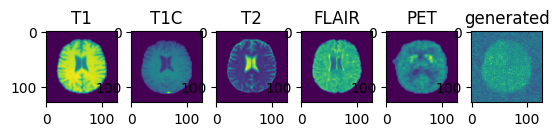

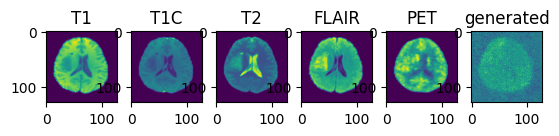

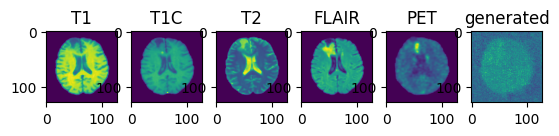

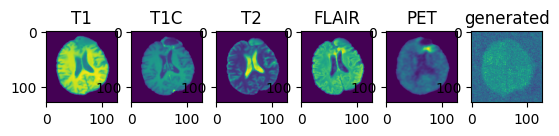

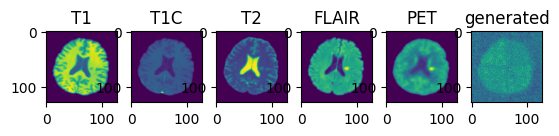

validation avg MS-SSIM: 0.3246 , train avg MS-SSIM: 0.3355
----------
epoch 11/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:17<14:15, 77.81s/it]

Epoch :  17%|██████                              | 2/12 [01:21<05:39, 33.95s/it]

Epoch :  25%|█████████                           | 3/12 [01:24<03:00, 20.10s/it]

Epoch :  33%|████████████                        | 4/12 [01:27<01:47, 13.46s/it]

Epoch :  42%|███████████████                     | 5/12 [01:31<01:08,  9.78s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:34<00:45,  7.56s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:37<00:30,  6.16s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:40<00:20,  5.23s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:44<00:13,  4.60s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:47<00:08,  4.15s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:50<00:03,  3.96s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:52<00:00,  3.38s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:56<00:00,  9.67s/it]

----------
epoch 12/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:17<14:11, 77.42s/it]

Epoch :  17%|██████                              | 2/12 [01:20<05:38, 33.82s/it]

Epoch :  25%|█████████                           | 3/12 [01:23<02:58, 19.87s/it]

Epoch :  33%|████████████                        | 4/12 [01:27<01:46, 13.30s/it]

Epoch :  42%|███████████████                     | 5/12 [01:30<01:07,  9.68s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:33<00:44,  7.49s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:36<00:30,  6.11s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:40<00:20,  5.20s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:43<00:13,  4.59s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:46<00:08,  4.17s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:49<00:03,  3.87s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:52<00:00,  3.33s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:55<00:00,  9.59s/it]

----------
epoch 13/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:19<14:38, 79.83s/it]

Epoch :  17%|██████                              | 2/12 [01:23<05:48, 34.83s/it]

Epoch :  25%|█████████                           | 3/12 [01:26<03:03, 20.41s/it]

Epoch :  33%|████████████                        | 4/12 [01:29<01:49, 13.63s/it]

Epoch :  42%|███████████████                     | 5/12 [01:32<01:09,  9.88s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:36<00:45,  7.62s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:39<00:30,  6.20s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:42<00:21,  5.36s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:46<00:14,  4.68s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:49<00:08,  4.26s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:52<00:03,  3.93s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:54<00:00,  3.35s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:57<00:00,  9.79s/it]

----------
epoch 14/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:16<13:57, 76.14s/it]

Epoch :  17%|██████                              | 2/12 [01:19<05:32, 33.26s/it]

Epoch :  25%|█████████                           | 3/12 [01:23<02:57, 19.74s/it]

Epoch :  33%|████████████                        | 4/12 [01:26<01:45, 13.22s/it]

Epoch :  42%|███████████████                     | 5/12 [01:29<01:07,  9.63s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:32<00:44,  7.45s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:35<00:30,  6.07s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:39<00:20,  5.19s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:42<00:13,  4.58s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:45<00:08,  4.14s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:49<00:03,  3.95s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:51<00:00,  3.35s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:54<00:00,  9.53s/it]

----------
epoch 15/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:17<14:14, 77.67s/it]

Epoch :  17%|██████                              | 2/12 [01:20<05:38, 33.90s/it]

Epoch :  25%|█████████                           | 3/12 [01:24<02:59, 19.90s/it]

Epoch :  33%|████████████                        | 4/12 [01:27<01:46, 13.36s/it]

Epoch :  42%|███████████████                     | 5/12 [01:30<01:07,  9.69s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:34<00:45,  7.61s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:37<00:30,  6.17s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:40<00:20,  5.23s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:43<00:13,  4.63s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:47<00:08,  4.19s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:50<00:03,  3.91s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:52<00:00,  3.34s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:55<00:00,  9.62s/it]

----------
epoch 16/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:19<14:32, 79.34s/it]

Epoch :  17%|██████                              | 2/12 [01:22<05:45, 34.57s/it]

Epoch :  25%|█████████                           | 3/12 [01:25<03:02, 20.29s/it]

Epoch :  33%|████████████                        | 4/12 [01:29<01:48, 13.53s/it]

Epoch :  42%|███████████████                     | 5/12 [01:32<01:08,  9.83s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:35<00:45,  7.58s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:38<00:30,  6.16s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:42<00:20,  5.24s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:45<00:14,  4.72s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:48<00:08,  4.28s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:52<00:03,  3.96s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:54<00:00,  3.39s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:57<00:00,  9.78s/it]

----------
epoch 17/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:17<14:10, 77.32s/it]

Epoch :  17%|██████                              | 2/12 [01:20<05:37, 33.75s/it]

Epoch :  25%|█████████                           | 3/12 [01:23<02:58, 19.85s/it]

Epoch :  33%|████████████                        | 4/12 [01:27<01:47, 13.45s/it]

Epoch :  42%|███████████████                     | 5/12 [01:30<01:08,  9.76s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:34<00:45,  7.57s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:37<00:30,  6.17s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:40<00:20,  5.22s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:43<00:13,  4.62s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:47<00:08,  4.20s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:50<00:03,  3.88s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:52<00:00,  3.39s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:55<00:00,  9.62s/it]

----------
epoch 18/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:17<14:07, 77.06s/it]

Epoch :  17%|██████                              | 2/12 [01:20<05:36, 33.63s/it]

Epoch :  25%|█████████                           | 3/12 [01:23<02:57, 19.76s/it]

Epoch :  33%|████████████                        | 4/12 [01:26<01:45, 13.24s/it]

Epoch :  42%|███████████████                     | 5/12 [01:30<01:07,  9.63s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:33<00:44,  7.49s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:36<00:31,  6.21s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:40<00:21,  5.26s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:43<00:13,  4.62s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:46<00:08,  4.20s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:49<00:03,  3.92s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:51<00:00,  3.35s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:54<00:00,  9.57s/it]

----------
epoch 19/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:14<13:43, 74.91s/it]

Epoch :  17%|██████                              | 2/12 [01:18<05:30, 33.06s/it]

Epoch :  25%|█████████                           | 3/12 [01:21<02:55, 19.46s/it]

Epoch :  33%|████████████                        | 4/12 [01:25<01:44, 13.05s/it]

Epoch :  42%|███████████████                     | 5/12 [01:28<01:06,  9.52s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:31<00:44,  7.38s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:34<00:30,  6.02s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:38<00:20,  5.14s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:41<00:13,  4.54s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:44<00:08,  4.22s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:48<00:03,  3.92s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:50<00:00,  3.34s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:53<00:00,  9.43s/it]

----------
epoch 20/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:20<14:41, 80.16s/it]

Epoch :  17%|██████                              | 2/12 [01:23<05:49, 34.91s/it]

Epoch :  25%|█████████                           | 3/12 [01:26<03:03, 20.44s/it]

Epoch :  33%|████████████                        | 4/12 [01:29<01:49, 13.65s/it]

Epoch :  42%|███████████████                     | 5/12 [01:33<01:10, 10.03s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:36<00:46,  7.71s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:39<00:31,  6.25s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:43<00:21,  5.28s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:46<00:13,  4.64s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:49<00:08,  4.19s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:52<00:03,  3.90s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:54<00:00,  3.34s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:58<00:00,  9.84s/it]

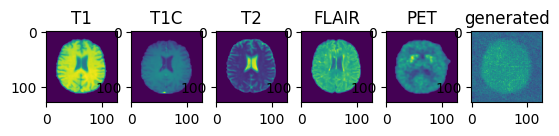

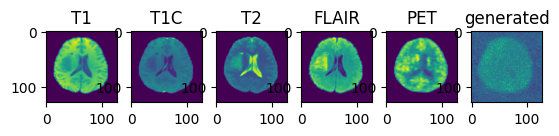

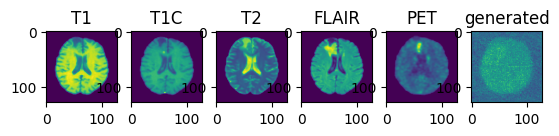

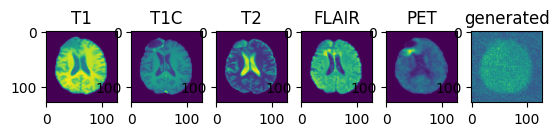

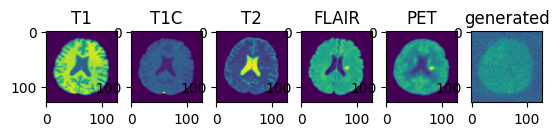

validation avg MS-SSIM: 0.3448 , train avg MS-SSIM: 0.3544
----------
epoch 21/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:17<14:16, 77.82s/it]

Epoch :  17%|██████                              | 2/12 [01:21<05:39, 33.95s/it]

Epoch :  25%|█████████                           | 3/12 [01:24<02:59, 19.95s/it]

Epoch :  33%|████████████                        | 4/12 [01:27<01:46, 13.34s/it]

Epoch :  42%|███████████████                     | 5/12 [01:30<01:07,  9.71s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:34<00:45,  7.51s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:37<00:30,  6.10s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:40<00:20,  5.20s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:43<00:13,  4.57s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:46<00:08,  4.16s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:50<00:03,  3.89s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:52<00:00,  3.42s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:55<00:00,  9.64s/it]

----------
epoch 22/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:18<14:18, 78.03s/it]

Epoch :  17%|██████                              | 2/12 [01:21<05:40, 34.00s/it]

Epoch :  25%|█████████                           | 3/12 [01:24<02:59, 19.97s/it]

Epoch :  33%|████████████                        | 4/12 [01:27<01:46, 13.37s/it]

Epoch :  42%|███████████████                     | 5/12 [01:31<01:08,  9.73s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:34<00:45,  7.51s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:37<00:31,  6.24s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:41<00:21,  5.29s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:44<00:13,  4.66s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:47<00:08,  4.23s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:50<00:03,  3.90s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:52<00:00,  3.32s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:56<00:00,  9.67s/it]

----------
epoch 23/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:18<14:22, 78.38s/it]

Epoch :  17%|██████                              | 2/12 [01:22<05:44, 34.42s/it]

Epoch :  25%|█████████                           | 3/12 [01:25<03:01, 20.18s/it]

Epoch :  33%|████████████                        | 4/12 [01:28<01:47, 13.48s/it]

Epoch :  42%|███████████████                     | 5/12 [01:31<01:08,  9.79s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:34<00:45,  7.55s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:38<00:30,  6.13s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:41<00:20,  5.20s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:44<00:13,  4.58s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:48<00:08,  4.25s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:51<00:03,  3.94s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:53<00:00,  3.35s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:56<00:00,  9.68s/it]

----------
epoch 24/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:17<14:12, 77.49s/it]

Epoch :  17%|██████                              | 2/12 [01:20<05:38, 33.82s/it]

Epoch :  25%|█████████                           | 3/12 [01:23<02:58, 19.85s/it]

Epoch :  33%|████████████                        | 4/12 [01:27<01:46, 13.30s/it]

Epoch :  42%|███████████████                     | 5/12 [01:30<01:07,  9.67s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:34<00:45,  7.64s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:37<00:30,  6.20s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:40<00:20,  5.25s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:43<00:13,  4.63s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:47<00:08,  4.20s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:50<00:03,  3.90s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:52<00:00,  3.35s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:55<00:00,  9.64s/it]

----------
epoch 25/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:19<14:31, 79.27s/it]

Epoch :  17%|██████                              | 2/12 [01:22<05:45, 34.54s/it]

Epoch :  25%|█████████                           | 3/12 [01:25<03:02, 20.26s/it]

Epoch :  33%|████████████                        | 4/12 [01:28<01:48, 13.53s/it]

Epoch :  42%|███████████████                     | 5/12 [01:32<01:08,  9.82s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:35<00:45,  7.58s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:38<00:30,  6.16s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:41<00:20,  5.24s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:45<00:14,  4.69s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:48<00:08,  4.26s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:51<00:03,  3.94s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:53<00:00,  3.35s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:56<00:00,  9.74s/it]

----------
epoch 26/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:18<14:18, 78.08s/it]

Epoch :  17%|██████                              | 2/12 [01:21<05:40, 34.04s/it]

Epoch :  25%|█████████                           | 3/12 [01:24<03:00, 20.05s/it]

Epoch :  33%|████████████                        | 4/12 [01:28<01:48, 13.56s/it]

Epoch :  42%|███████████████                     | 5/12 [01:31<01:08,  9.85s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:35<00:45,  7.66s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:38<00:31,  6.21s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:41<00:21,  5.28s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:44<00:13,  4.63s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:48<00:08,  4.22s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:51<00:04,  4.03s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:53<00:00,  3.42s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:56<00:00,  9.70s/it]

----------
epoch 27/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:17<14:10, 77.29s/it]

Epoch :  17%|██████                              | 2/12 [01:20<05:37, 33.72s/it]

Epoch :  25%|█████████                           | 3/12 [01:23<02:58, 19.84s/it]

Epoch :  33%|████████████                        | 4/12 [01:27<01:46, 13.29s/it]

Epoch :  42%|███████████████                     | 5/12 [01:30<01:07,  9.68s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:33<00:44,  7.49s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:37<00:31,  6.24s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:40<00:21,  5.27s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:43<00:13,  4.63s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:46<00:08,  4.22s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:50<00:03,  3.91s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:52<00:00,  3.32s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:55<00:00,  9.62s/it]

----------
epoch 28/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:17<14:10, 77.29s/it]

Epoch :  17%|██████                              | 2/12 [01:20<05:39, 33.95s/it]

Epoch :  25%|█████████                           | 3/12 [01:24<02:59, 19.92s/it]

Epoch :  33%|████████████                        | 4/12 [01:27<01:46, 13.32s/it]

Epoch :  42%|███████████████                     | 5/12 [01:30<01:07,  9.68s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:33<00:45,  7.52s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:37<00:30,  6.11s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:40<00:20,  5.20s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:43<00:14,  4.67s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:47<00:08,  4.23s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:50<00:03,  3.92s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:52<00:00,  3.37s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:55<00:00,  9.62s/it]

----------
epoch 29/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:19<14:31, 79.21s/it]

Epoch :  17%|██████                              | 2/12 [01:22<05:44, 34.50s/it]

Epoch :  25%|█████████                           | 3/12 [01:25<03:02, 20.26s/it]

Epoch :  33%|████████████                        | 4/12 [01:29<01:49, 13.68s/it]

Epoch :  42%|███████████████                     | 5/12 [01:32<01:09,  9.94s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:35<00:46,  7.67s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:39<00:31,  6.22s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:42<00:21,  5.28s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:45<00:13,  4.64s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:48<00:08,  4.25s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:52<00:03,  3.94s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:54<00:00,  3.44s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:57<00:00,  9.79s/it]

----------
epoch 30/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:20<14:40, 80.08s/it]

Epoch :  17%|██████                              | 2/12 [01:23<05:48, 34.86s/it]

Epoch :  25%|█████████                           | 3/12 [01:26<03:03, 20.40s/it]

Epoch :  33%|████████████                        | 4/12 [01:29<01:49, 13.65s/it]

Epoch :  42%|███████████████                     | 5/12 [01:32<01:09,  9.87s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:36<00:45,  7.64s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:39<00:31,  6.31s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:43<00:21,  5.36s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:46<00:14,  4.69s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:49<00:08,  4.23s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:52<00:03,  3.93s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:54<00:00,  3.37s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:58<00:00,  9.84s/it]

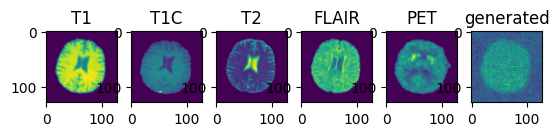

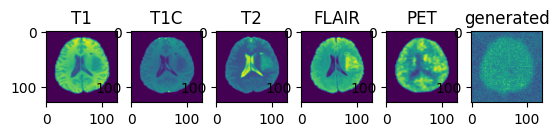

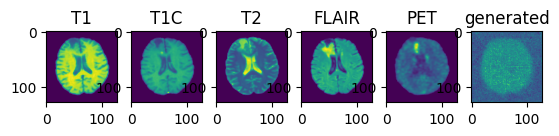

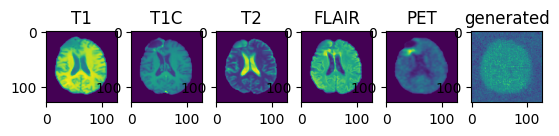

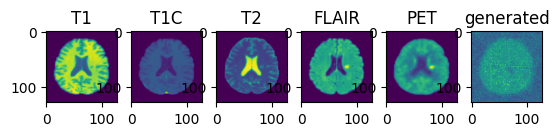

validation avg MS-SSIM: 0.3447 , train avg MS-SSIM: 0.3555
----------
epoch 31/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:20<14:46, 80.61s/it]

Epoch :  17%|██████                              | 2/12 [01:23<05:51, 35.10s/it]

Epoch :  25%|█████████                           | 3/12 [01:27<03:05, 20.56s/it]

Epoch :  33%|████████████                        | 4/12 [01:30<01:50, 13.76s/it]

Epoch :  42%|███████████████                     | 5/12 [01:33<01:09,  9.98s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:37<00:47,  7.84s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:40<00:31,  6.33s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:43<00:21,  5.35s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:47<00:14,  4.69s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:50<00:08,  4.25s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:53<00:03,  3.95s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:55<00:00,  3.35s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:58<00:00,  9.87s/it]

----------
epoch 32/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:20<14:44, 80.45s/it]

Epoch :  17%|██████                              | 2/12 [01:23<05:50, 35.06s/it]

Epoch :  25%|█████████                           | 3/12 [01:26<03:04, 20.50s/it]

Epoch :  33%|████████████                        | 4/12 [01:30<01:49, 13.69s/it]

Epoch :  42%|███████████████                     | 5/12 [01:33<01:09,  9.92s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:36<00:45,  7.64s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:39<00:31,  6.21s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:43<00:21,  5.36s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:46<00:14,  4.70s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:49<00:08,  4.24s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:53<00:03,  3.92s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:55<00:00,  3.35s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:58<00:00,  9.85s/it]

----------
epoch 33/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:17<14:10, 77.30s/it]

Epoch :  17%|██████                              | 2/12 [01:20<05:37, 33.76s/it]

Epoch :  25%|█████████                           | 3/12 [01:24<03:00, 20.02s/it]

Epoch :  33%|████████████                        | 4/12 [01:27<01:47, 13.40s/it]

Epoch :  42%|███████████████                     | 5/12 [01:30<01:08,  9.76s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:33<00:45,  7.53s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:37<00:30,  6.12s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:40<00:20,  5.20s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:43<00:13,  4.58s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:46<00:08,  4.15s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:50<00:03,  3.88s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:52<00:00,  3.33s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:55<00:00,  9.62s/it]

----------
epoch 34/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:18<14:19, 78.13s/it]

Epoch :  17%|██████                              | 2/12 [01:21<05:41, 34.10s/it]

Epoch :  25%|█████████                           | 3/12 [01:24<03:00, 20.00s/it]

Epoch :  33%|████████████                        | 4/12 [01:27<01:47, 13.39s/it]

Epoch :  42%|███████████████                     | 5/12 [01:31<01:08,  9.72s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:34<00:45,  7.63s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:37<00:30,  6.19s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:41<00:20,  5.22s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:44<00:13,  4.61s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:47<00:08,  4.17s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:50<00:03,  3.91s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:52<00:00,  3.34s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:56<00:00,  9.67s/it]

----------
epoch 35/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:18<14:24, 78.63s/it]

Epoch :  17%|██████                              | 2/12 [01:22<05:45, 34.57s/it]

Epoch :  25%|█████████                           | 3/12 [01:25<03:02, 20.26s/it]

Epoch :  33%|████████████                        | 4/12 [01:28<01:48, 13.55s/it]

Epoch :  42%|███████████████                     | 5/12 [01:32<01:08,  9.84s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:35<00:45,  7.59s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:38<00:30,  6.17s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:41<00:20,  5.22s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:45<00:13,  4.60s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:48<00:08,  4.28s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:51<00:03,  3.96s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:53<00:00,  3.37s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:56<00:00,  9.73s/it]

----------
epoch 36/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:18<14:28, 78.92s/it]

Epoch :  17%|██████                              | 2/12 [01:22<05:43, 34.38s/it]

Epoch :  25%|█████████                           | 3/12 [01:25<03:01, 20.17s/it]

Epoch :  33%|████████████                        | 4/12 [01:28<01:47, 13.45s/it]

Epoch :  42%|███████████████                     | 5/12 [01:32<01:09,  9.88s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:35<00:45,  7.63s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:38<00:30,  6.18s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:41<00:21,  5.26s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:45<00:13,  4.62s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:48<00:08,  4.19s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:51<00:03,  3.90s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:53<00:00,  3.34s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:56<00:00,  9.73s/it]

----------
epoch 37/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:19<14:35, 79.59s/it]

Epoch :  17%|██████                              | 2/12 [01:22<05:46, 34.70s/it]

Epoch :  25%|█████████                           | 3/12 [01:26<03:03, 20.36s/it]

Epoch :  33%|████████████                        | 4/12 [01:29<01:48, 13.58s/it]

Epoch :  42%|███████████████                     | 5/12 [01:32<01:09,  9.87s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:35<00:45,  7.63s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:39<00:30,  6.19s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:42<00:21,  5.26s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:45<00:14,  4.71s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:49<00:08,  4.26s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:52<00:03,  3.94s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:54<00:00,  3.35s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:57<00:00,  9.76s/it]

----------
epoch 38/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:18<14:27, 78.89s/it]

Epoch :  17%|██████                              | 2/12 [01:22<05:43, 34.38s/it]

Epoch :  25%|█████████                           | 3/12 [01:25<03:01, 20.19s/it]

Epoch :  33%|████████████                        | 4/12 [01:29<01:49, 13.64s/it]

Epoch :  42%|███████████████                     | 5/12 [01:32<01:09,  9.90s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:35<00:45,  7.62s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:38<00:31,  6.20s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:42<00:21,  5.29s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:45<00:13,  4.64s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:48<00:08,  4.21s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:51<00:03,  3.92s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:54<00:00,  3.45s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:57<00:00,  9.76s/it]

----------
epoch 39/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:18<14:23, 78.47s/it]

Epoch :  17%|██████                              | 2/12 [01:21<05:42, 34.25s/it]

Epoch :  25%|█████████                           | 3/12 [01:25<03:01, 20.11s/it]

Epoch :  33%|████████████                        | 4/12 [01:28<01:47, 13.45s/it]

Epoch :  42%|███████████████                     | 5/12 [01:31<01:08,  9.77s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:34<00:45,  7.58s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:38<00:30,  6.16s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:41<00:21,  5.37s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:45<00:14,  4.72s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:48<00:08,  4.31s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:51<00:03,  3.96s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:53<00:00,  3.41s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:56<00:00,  9.73s/it]

----------
epoch 40/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:18<14:27, 78.82s/it]

Epoch :  17%|██████                              | 2/12 [01:21<05:43, 34.31s/it]

Epoch :  25%|█████████                           | 3/12 [01:25<03:01, 20.21s/it]

Epoch :  33%|████████████                        | 4/12 [01:28<01:48, 13.51s/it]

Epoch :  42%|███████████████                     | 5/12 [01:31<01:08,  9.80s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:35<00:45,  7.57s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:38<00:30,  6.15s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:41<00:20,  5.21s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:44<00:13,  4.62s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:48<00:08,  4.20s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:51<00:04,  4.02s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:53<00:00,  3.41s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:56<00:00,  9.73s/it]

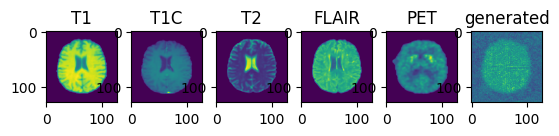

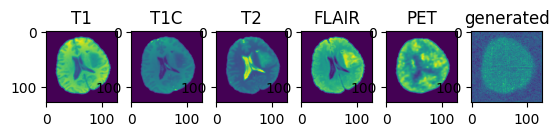

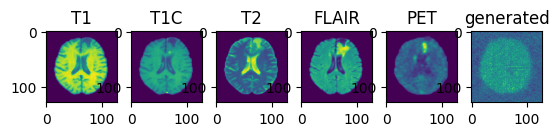

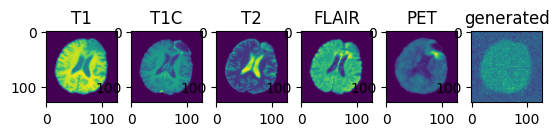

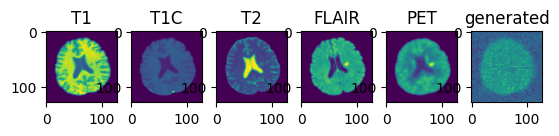

validation avg MS-SSIM: 0.3487 , train avg MS-SSIM: 0.3655
----------
epoch 41/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:19<14:39, 79.98s/it]

Epoch :  17%|██████                              | 2/12 [01:23<05:51, 35.11s/it]

Epoch :  25%|█████████                           | 3/12 [01:26<03:04, 20.54s/it]

Epoch :  33%|████████████                        | 4/12 [01:30<01:49, 13.73s/it]

Epoch :  42%|███████████████                     | 5/12 [01:33<01:09,  9.94s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:36<00:46,  7.67s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:39<00:31,  6.22s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:43<00:21,  5.26s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:46<00:13,  4.62s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:49<00:08,  4.27s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:53<00:03,  3.96s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:54<00:00,  3.35s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:58<00:00,  9.88s/it]

----------
epoch 42/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:19<14:39, 79.95s/it]

Epoch :  17%|██████                              | 2/12 [01:23<05:48, 34.82s/it]

Epoch :  25%|█████████                           | 3/12 [01:26<03:03, 20.38s/it]

Epoch :  33%|████████████                        | 4/12 [01:29<01:48, 13.61s/it]

Epoch :  42%|███████████████                     | 5/12 [01:33<01:10, 10.01s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:36<00:46,  7.70s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:39<00:31,  6.22s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:42<00:21,  5.26s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:46<00:13,  4.63s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:49<00:08,  4.18s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:52<00:03,  3.90s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:54<00:00,  3.34s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:57<00:00,  9.77s/it]

----------
epoch 43/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:20<14:45, 80.48s/it]

Epoch :  17%|██████                              | 2/12 [01:23<05:50, 35.09s/it]

Epoch :  25%|█████████                           | 3/12 [01:27<03:04, 20.55s/it]

Epoch :  33%|████████████                        | 4/12 [01:30<01:49, 13.72s/it]

Epoch :  42%|███████████████                     | 5/12 [01:33<01:09,  9.96s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:36<00:46,  7.69s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:40<00:31,  6.22s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:43<00:21,  5.40s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:46<00:14,  4.72s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:50<00:08,  4.28s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:53<00:03,  3.94s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:55<00:00,  3.34s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:58<00:00,  9.87s/it]

----------
epoch 44/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:20<14:45, 80.54s/it]

Epoch :  17%|██████                              | 2/12 [01:23<05:51, 35.11s/it]

Epoch :  25%|█████████                           | 3/12 [01:27<03:06, 20.74s/it]

Epoch :  33%|████████████                        | 4/12 [01:30<01:50, 13.85s/it]

Epoch :  42%|███████████████                     | 5/12 [01:34<01:10, 10.05s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:37<00:46,  7.71s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:40<00:31,  6.24s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:43<00:21,  5.28s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:46<00:13,  4.62s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:50<00:08,  4.29s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:53<00:03,  3.99s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:55<00:00,  3.39s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:58<00:00,  9.89s/it]

----------
epoch 45/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:17<14:14, 77.68s/it]

Epoch :  17%|██████                              | 2/12 [01:20<05:38, 33.86s/it]

Epoch :  25%|█████████                           | 3/12 [01:24<02:58, 19.87s/it]

Epoch :  33%|████████████                        | 4/12 [01:27<01:46, 13.30s/it]

Epoch :  42%|███████████████                     | 5/12 [01:30<01:08,  9.81s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:34<00:45,  7.59s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:37<00:30,  6.16s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:40<00:20,  5.23s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:43<00:13,  4.60s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:47<00:08,  4.17s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:50<00:03,  3.88s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:52<00:00,  3.43s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:55<00:00,  9.64s/it]

----------
epoch 46/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:17<14:12, 77.46s/it]

Epoch :  17%|██████                              | 2/12 [01:20<05:37, 33.79s/it]

Epoch :  25%|█████████                           | 3/12 [01:23<02:58, 19.85s/it]

Epoch :  33%|████████████                        | 4/12 [01:27<01:46, 13.30s/it]

Epoch :  42%|███████████████                     | 5/12 [01:30<01:07,  9.65s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:33<00:44,  7.47s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:36<00:30,  6.09s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:40<00:21,  5.30s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:43<00:14,  4.67s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:47<00:08,  4.26s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:50<00:03,  3.95s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:52<00:00,  3.35s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:55<00:00,  9.64s/it]

----------
epoch 47/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:20<14:45, 80.51s/it]

Epoch :  17%|██████                              | 2/12 [01:23<05:50, 35.06s/it]

Epoch :  25%|█████████                           | 3/12 [01:27<03:06, 20.72s/it]

Epoch :  33%|████████████                        | 4/12 [01:30<01:51, 13.89s/it]

Epoch :  42%|███████████████                     | 5/12 [01:34<01:10, 10.08s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:37<00:46,  7.75s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:40<00:31,  6.30s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:43<00:21,  5.34s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:47<00:14,  4.68s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:50<00:08,  4.34s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:54<00:04,  4.00s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:56<00:00,  3.41s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:59<00:00,  9.93s/it]

----------
epoch 48/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:19<14:30, 79.15s/it]

Epoch :  17%|██████                              | 2/12 [01:22<05:45, 34.51s/it]

Epoch :  25%|█████████                           | 3/12 [01:25<03:02, 20.27s/it]

Epoch :  33%|████████████                        | 4/12 [01:29<01:48, 13.56s/it]

Epoch :  42%|███████████████                     | 5/12 [01:32<01:08,  9.84s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:35<00:46,  7.76s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:39<00:31,  6.28s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:42<00:21,  5.31s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:45<00:13,  4.66s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:48<00:08,  4.21s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:52<00:03,  3.91s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:54<00:00,  3.36s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:57<00:00,  9.78s/it]

----------
epoch 49/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:21<14:53, 81.19s/it]

Epoch :  17%|██████                              | 2/12 [01:24<05:55, 35.56s/it]

Epoch :  25%|█████████                           | 3/12 [01:28<03:07, 20.81s/it]

Epoch :  33%|████████████                        | 4/12 [01:31<01:51, 13.90s/it]

Epoch :  42%|███████████████                     | 5/12 [01:34<01:10, 10.06s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:37<00:46,  7.74s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:41<00:31,  6.27s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:44<00:21,  5.31s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:47<00:14,  4.67s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:51<00:08,  4.34s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:54<00:04,  4.01s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:56<00:00,  3.42s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:59<00:00,  9.98s/it]

----------
epoch 50/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:17<14:16, 77.89s/it]

Epoch :  17%|██████                              | 2/12 [01:21<05:40, 34.00s/it]

Epoch :  25%|█████████                           | 3/12 [01:24<02:59, 19.98s/it]

Epoch :  33%|████████████                        | 4/12 [01:27<01:47, 13.38s/it]

Epoch :  42%|███████████████                     | 5/12 [01:31<01:08,  9.84s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:34<00:45,  7.59s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:37<00:30,  6.18s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:41<00:20,  5.25s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:44<00:13,  4.60s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:47<00:08,  4.19s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:50<00:03,  3.97s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:52<00:00,  3.37s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:55<00:00,  9.66s/it]

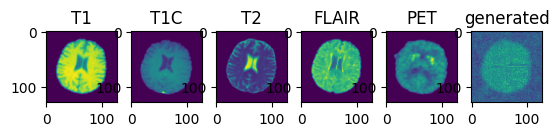

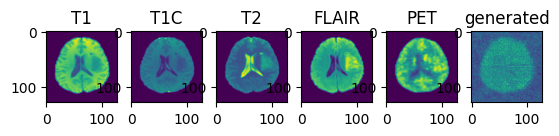

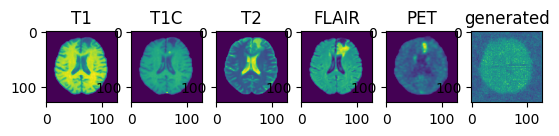

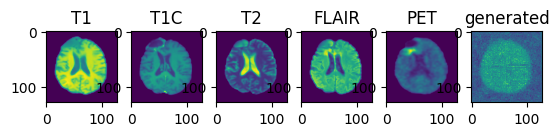

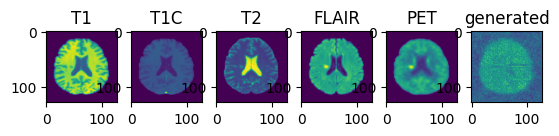

validation avg MS-SSIM: 0.3585 , train avg MS-SSIM: 0.3717
----------
epoch 51/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:21<14:55, 81.42s/it]

Epoch :  17%|██████                              | 2/12 [01:24<05:54, 35.45s/it]

Epoch :  25%|█████████                           | 3/12 [01:27<03:06, 20.73s/it]

Epoch :  33%|████████████                        | 4/12 [01:31<01:51, 14.00s/it]

Epoch :  42%|███████████████                     | 5/12 [01:34<01:10, 10.12s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:38<00:46,  7.79s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:41<00:31,  6.32s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:44<00:21,  5.35s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:47<00:14,  4.70s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:51<00:08,  4.24s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:54<00:04,  4.02s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:56<00:00,  3.40s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:59<00:00,  9.96s/it]

----------
epoch 52/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:20<14:45, 80.51s/it]

Epoch :  17%|██████                              | 2/12 [01:23<05:50, 35.05s/it]

Epoch :  25%|█████████                           | 3/12 [01:27<03:04, 20.55s/it]

Epoch :  33%|████████████                        | 4/12 [01:30<01:49, 13.70s/it]

Epoch :  42%|███████████████                     | 5/12 [01:33<01:09,  9.94s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:36<00:46,  7.68s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:40<00:31,  6.35s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:43<00:21,  5.37s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:46<00:14,  4.69s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:50<00:08,  4.24s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:53<00:03,  3.95s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:55<00:00,  3.35s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:58<00:00,  9.86s/it]

----------
epoch 53/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:18<14:26, 78.80s/it]

Epoch :  17%|██████                              | 2/12 [01:22<05:45, 34.57s/it]

Epoch :  25%|█████████                           | 3/12 [01:25<03:02, 20.28s/it]

Epoch :  33%|████████████                        | 4/12 [01:28<01:48, 13.56s/it]

Epoch :  42%|███████████████                     | 5/12 [01:32<01:08,  9.84s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:35<00:45,  7.58s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:38<00:30,  6.14s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:41<00:20,  5.23s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:45<00:13,  4.61s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:48<00:08,  4.27s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:51<00:03,  3.95s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:53<00:00,  3.37s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:56<00:00,  9.74s/it]

----------
epoch 54/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:19<14:38, 79.85s/it]

Epoch :  17%|██████                              | 2/12 [01:23<05:47, 34.79s/it]

Epoch :  25%|█████████                           | 3/12 [01:26<03:03, 20.40s/it]

Epoch :  33%|████████████                        | 4/12 [01:29<01:48, 13.62s/it]

Epoch :  42%|███████████████                     | 5/12 [01:33<01:10, 10.00s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:36<00:46,  7.70s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:39<00:31,  6.24s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:42<00:21,  5.27s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:46<00:13,  4.63s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:49<00:08,  4.20s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:52<00:03,  3.90s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:54<00:00,  3.32s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:57<00:00,  9.80s/it]

----------
epoch 55/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:19<14:34, 79.53s/it]

Epoch :  17%|██████                              | 2/12 [01:22<05:46, 34.64s/it]

Epoch :  25%|█████████                           | 3/12 [01:25<03:02, 20.29s/it]

Epoch :  33%|████████████                        | 4/12 [01:29<01:48, 13.57s/it]

Epoch :  42%|███████████████                     | 5/12 [01:32<01:08,  9.86s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:35<00:45,  7.62s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:39<00:30,  6.19s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:42<00:20,  5.25s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:45<00:14,  4.71s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:49<00:08,  4.26s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:52<00:03,  3.98s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:54<00:00,  3.40s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:57<00:00,  9.79s/it]

----------
epoch 56/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:20<14:41, 80.10s/it]

Epoch :  17%|██████                              | 2/12 [01:23<05:48, 34.90s/it]

Epoch :  25%|█████████                           | 3/12 [01:26<03:04, 20.47s/it]

Epoch :  33%|████████████                        | 4/12 [01:30<01:50, 13.83s/it]

Epoch :  42%|███████████████                     | 5/12 [01:33<01:10, 10.02s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:36<00:46,  7.75s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:40<00:31,  6.27s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:43<00:21,  5.31s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:46<00:13,  4.67s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:49<00:08,  4.23s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:53<00:03,  3.92s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:55<00:00,  3.44s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:58<00:00,  9.89s/it]

----------
epoch 57/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:16<14:01, 76.52s/it]

Epoch :  17%|██████                              | 2/12 [01:19<05:34, 33.47s/it]

Epoch :  25%|█████████                           | 3/12 [01:23<02:56, 19.66s/it]

Epoch :  33%|████████████                        | 4/12 [01:26<01:45, 13.20s/it]

Epoch :  42%|███████████████                     | 5/12 [01:29<01:07,  9.59s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:32<00:44,  7.43s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:36<00:30,  6.05s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:39<00:21,  5.26s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:42<00:13,  4.63s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:46<00:08,  4.20s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:49<00:03,  3.89s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:51<00:00,  3.34s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:54<00:00,  9.52s/it]

----------
epoch 58/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:19<14:34, 79.49s/it]

Epoch :  17%|██████                              | 2/12 [01:22<05:46, 34.66s/it]

Epoch :  25%|█████████                           | 3/12 [01:26<03:04, 20.52s/it]

Epoch :  33%|████████████                        | 4/12 [01:29<01:49, 13.69s/it]

Epoch :  42%|███████████████                     | 5/12 [01:32<01:09,  9.93s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:36<00:45,  7.65s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:39<00:31,  6.28s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:42<00:21,  5.32s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:46<00:14,  4.67s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:49<00:08,  4.23s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:52<00:04,  4.02s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:54<00:00,  3.42s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:57<00:00,  9.83s/it]

----------
epoch 59/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:20<14:49, 80.82s/it]

Epoch :  17%|██████                              | 2/12 [01:24<05:51, 35.19s/it]

Epoch :  25%|█████████                           | 3/12 [01:27<03:05, 20.61s/it]

Epoch :  33%|████████████                        | 4/12 [01:30<01:49, 13.73s/it]

Epoch :  42%|███████████████                     | 5/12 [01:33<01:09,  9.97s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:37<00:47,  7.85s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:40<00:31,  6.35s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:44<00:21,  5.36s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:47<00:14,  4.70s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:50<00:08,  4.26s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:53<00:03,  3.94s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:55<00:00,  3.35s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:59<00:00,  9.93s/it]

----------
epoch 60/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:20<14:42, 80.26s/it]

Epoch :  17%|██████                              | 2/12 [01:23<05:49, 34.96s/it]

Epoch :  25%|█████████                           | 3/12 [01:26<03:04, 20.52s/it]

Epoch :  33%|████████████                        | 4/12 [01:30<01:49, 13.69s/it]

Epoch :  42%|███████████████                     | 5/12 [01:33<01:09,  9.99s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:36<00:46,  7.73s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:40<00:31,  6.26s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:43<00:21,  5.43s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:47<00:14,  4.76s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:50<00:08,  4.31s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:53<00:03,  3.99s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:55<00:00,  3.40s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:58<00:00,  9.90s/it]

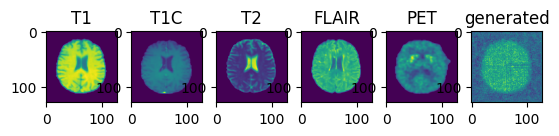

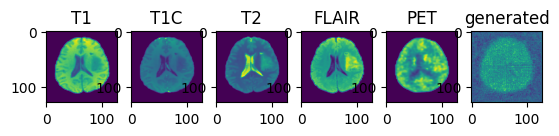

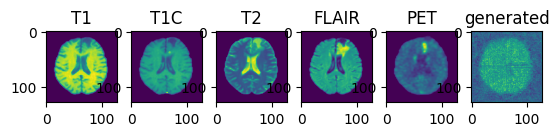

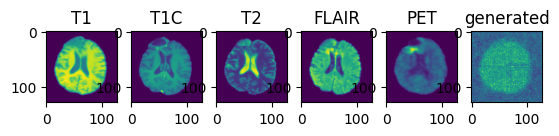

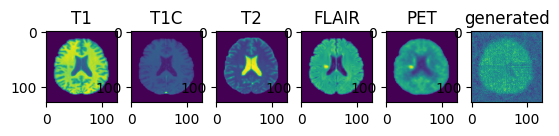

validation avg MS-SSIM: 0.3614 , train avg MS-SSIM: 0.3738
----------
epoch 61/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:28<16:08, 88.02s/it]

Epoch :  17%|██████                              | 2/12 [01:31<06:21, 38.17s/it]

Epoch :  25%|█████████                           | 3/12 [01:34<03:20, 22.27s/it]

Epoch :  33%|████████████                        | 4/12 [01:37<01:57, 14.73s/it]

Epoch :  42%|███████████████                     | 5/12 [01:41<01:14, 10.60s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:44<00:49,  8.26s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:48<00:33,  6.63s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:51<00:22,  5.53s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:54<00:14,  4.84s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:57<00:08,  4.34s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [02:01<00:04,  4.02s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [02:03<00:00,  3.43s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [02:06<00:00, 10.53s/it]

----------
epoch 62/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:26<15:49, 86.30s/it]

Epoch :  17%|██████                              | 2/12 [01:29<06:17, 37.71s/it]

Epoch :  25%|█████████                           | 3/12 [01:33<03:18, 22.00s/it]

Epoch :  33%|████████████                        | 4/12 [01:36<01:56, 14.59s/it]

Epoch :  42%|███████████████                     | 5/12 [01:39<01:13, 10.51s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:43<00:48,  8.07s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:46<00:32,  6.50s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:49<00:21,  5.49s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:52<00:14,  4.79s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:56<00:08,  4.42s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:59<00:04,  4.06s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [02:01<00:00,  3.45s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [02:05<00:00, 10.42s/it]

----------
epoch 63/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:25<15:42, 85.66s/it]

Epoch :  17%|██████                              | 2/12 [01:29<06:12, 37.25s/it]

Epoch :  25%|█████████                           | 3/12 [01:32<03:15, 21.75s/it]

Epoch :  33%|████████████                        | 4/12 [01:35<01:55, 14.46s/it]

Epoch :  42%|███████████████                     | 5/12 [01:39<01:13, 10.56s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:42<00:48,  8.10s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:45<00:32,  6.51s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:49<00:21,  5.49s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:52<00:14,  4.79s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:55<00:08,  4.35s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:59<00:04,  4.02s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [02:01<00:00,  3.44s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [02:04<00:00, 10.37s/it]

----------
epoch 64/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:25<15:35, 85.01s/it]

Epoch :  17%|██████                              | 2/12 [01:28<06:09, 36.97s/it]

Epoch :  25%|█████████                           | 3/12 [01:31<03:14, 21.61s/it]

Epoch :  33%|████████████                        | 4/12 [01:35<01:55, 14.41s/it]

Epoch :  42%|███████████████                     | 5/12 [01:38<01:12, 10.41s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:41<00:47,  7.99s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:44<00:32,  6.45s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:48<00:21,  5.43s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:51<00:14,  4.88s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:55<00:08,  4.38s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:58<00:04,  4.08s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [02:00<00:00,  3.46s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [02:03<00:00, 10.29s/it]

----------
epoch 65/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:23<15:19, 83.61s/it]

Epoch :  17%|██████                              | 2/12 [01:26<06:04, 36.40s/it]

Epoch :  25%|█████████                           | 3/12 [01:30<03:12, 21.34s/it]

Epoch :  33%|████████████                        | 4/12 [01:34<01:55, 14.40s/it]

Epoch :  42%|███████████████                     | 5/12 [01:37<01:12, 10.39s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:40<00:47,  8.00s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:44<00:32,  6.46s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:47<00:21,  5.48s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:50<00:14,  4.78s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:53<00:08,  4.31s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:57<00:03,  4.00s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:59<00:00,  3.49s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [02:02<00:00, 10.21s/it]

----------
epoch 66/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:26<15:52, 86.57s/it]

Epoch :  17%|██████                              | 2/12 [01:29<06:15, 37.55s/it]

Epoch :  25%|█████████                           | 3/12 [01:33<03:17, 21.90s/it]

Epoch :  33%|████████████                        | 4/12 [01:36<01:56, 14.57s/it]

Epoch :  42%|███████████████                     | 5/12 [01:39<01:13, 10.51s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:43<00:48,  8.06s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:46<00:33,  6.62s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:50<00:22,  5.60s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:53<00:14,  4.87s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:56<00:08,  4.38s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [02:00<00:04,  4.08s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [02:02<00:00,  3.48s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [02:05<00:00, 10.42s/it]

----------
epoch 67/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:27<16:03, 87.55s/it]

Epoch :  17%|██████                              | 2/12 [01:30<06:20, 38.02s/it]

Epoch :  25%|█████████                           | 3/12 [01:34<03:21, 22.35s/it]

Epoch :  33%|████████████                        | 4/12 [01:37<01:58, 14.85s/it]

Epoch :  42%|███████████████                     | 5/12 [01:41<01:14, 10.67s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:44<00:48,  8.13s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:47<00:32,  6.56s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:50<00:22,  5.50s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:54<00:14,  4.79s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:57<00:08,  4.43s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [02:01<00:04,  4.07s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [02:03<00:00,  3.44s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [02:06<00:00, 10.50s/it]

----------
epoch 68/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:25<15:40, 85.50s/it]

Epoch :  17%|██████                              | 2/12 [01:28<06:11, 37.16s/it]

Epoch :  25%|█████████                           | 3/12 [01:32<03:15, 21.72s/it]

Epoch :  33%|████████████                        | 4/12 [01:35<01:55, 14.42s/it]

Epoch :  42%|███████████████                     | 5/12 [01:38<01:12, 10.42s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:42<00:48,  8.12s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:45<00:32,  6.59s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:49<00:22,  5.53s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:52<00:14,  4.81s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:55<00:08,  4.36s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:58<00:04,  4.02s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [02:00<00:00,  3.41s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [02:03<00:00, 10.30s/it]

----------
epoch 69/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:27<16:00, 87.28s/it]

Epoch :  17%|██████                              | 2/12 [01:30<06:19, 37.97s/it]

Epoch :  25%|█████████                           | 3/12 [01:34<03:19, 22.15s/it]

Epoch :  33%|████████████                        | 4/12 [01:37<01:57, 14.71s/it]

Epoch :  42%|███████████████                     | 5/12 [01:40<01:14, 10.63s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:44<00:48,  8.13s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:47<00:32,  6.60s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:50<00:22,  5.60s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:54<00:15,  5.01s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:58<00:09,  4.53s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [02:01<00:04,  4.19s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [02:03<00:00,  3.57s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [02:06<00:00, 10.57s/it]

----------
epoch 70/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:29<16:27, 89.81s/it]

Epoch :  17%|██████                              | 2/12 [01:33<06:29, 38.91s/it]

Epoch :  25%|█████████                           | 3/12 [01:36<03:23, 22.66s/it]

Epoch :  33%|████████████                        | 4/12 [01:40<02:01, 15.20s/it]

Epoch :  42%|███████████████                     | 5/12 [01:43<01:16, 10.95s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:46<00:50,  8.36s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:50<00:33,  6.71s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:53<00:22,  5.65s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:56<00:14,  4.93s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [02:00<00:08,  4.45s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [02:03<00:04,  4.15s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [02:06<00:00,  3.66s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [02:09<00:00, 10.78s/it]

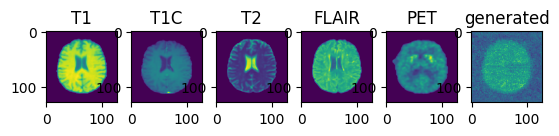

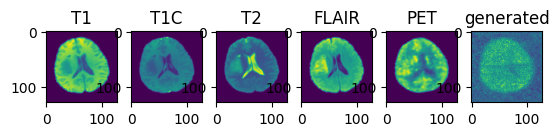

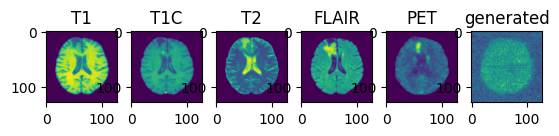

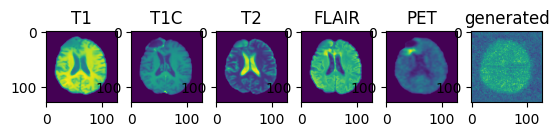

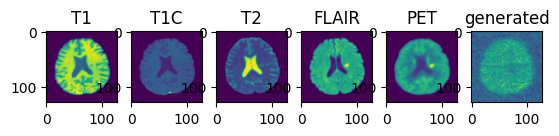

validation avg MS-SSIM: 0.3600 , train avg MS-SSIM: 0.3746
----------
epoch 71/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:23<15:13, 83.03s/it]

Epoch :  17%|██████                              | 2/12 [01:26<06:01, 36.14s/it]

Epoch :  25%|█████████                           | 3/12 [01:29<03:10, 21.11s/it]

Epoch :  33%|████████████                        | 4/12 [01:32<01:52, 14.09s/it]

Epoch :  42%|███████████████                     | 5/12 [01:36<01:12, 10.38s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:39<00:47,  7.94s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:43<00:32,  6.43s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:46<00:21,  5.42s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:49<00:14,  4.74s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:53<00:08,  4.29s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:56<00:03,  3.98s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:58<00:00,  3.50s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [02:01<00:00, 10.12s/it]

----------
epoch 72/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:27<16:04, 87.72s/it]

Epoch :  17%|██████                              | 2/12 [01:31<06:20, 38.06s/it]

Epoch :  25%|█████████                           | 3/12 [01:34<03:19, 22.18s/it]

Epoch :  33%|████████████                        | 4/12 [01:37<01:57, 14.70s/it]

Epoch :  42%|███████████████                     | 5/12 [01:40<01:14, 10.59s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:44<00:48,  8.11s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:47<00:32,  6.52s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:51<00:22,  5.61s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:54<00:14,  4.87s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:57<00:08,  4.40s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [02:00<00:04,  4.04s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [02:02<00:00,  3.44s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [02:05<00:00, 10.49s/it]

----------
epoch 73/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:26<15:49, 86.28s/it]

Epoch :  17%|██████                              | 2/12 [01:29<06:15, 37.53s/it]

Epoch :  25%|█████████                           | 3/12 [01:33<03:18, 22.09s/it]

Epoch :  33%|████████████                        | 4/12 [01:36<01:57, 14.72s/it]

Epoch :  42%|███████████████                     | 5/12 [01:40<01:14, 10.61s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:43<00:48,  8.10s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:46<00:32,  6.52s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:49<00:22,  5.50s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:53<00:14,  4.82s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:56<00:08,  4.40s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [02:00<00:04,  4.07s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [02:02<00:00,  3.47s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [02:04<00:00, 10.41s/it]

----------
epoch 74/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:25<15:45, 85.93s/it]

Epoch :  17%|██████                              | 2/12 [01:29<06:12, 37.28s/it]

Epoch :  25%|█████████                           | 3/12 [01:32<03:15, 21.78s/it]

Epoch :  33%|████████████                        | 4/12 [01:35<01:56, 14.51s/it]

Epoch :  42%|███████████████                     | 5/12 [01:39<01:13, 10.50s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:42<00:49,  8.20s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:46<00:32,  6.59s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:49<00:22,  5.57s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:52<00:14,  4.87s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:56<00:08,  4.40s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:59<00:04,  4.12s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [02:01<00:00,  3.50s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [02:04<00:00, 10.41s/it]

----------
epoch 75/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:28<16:18, 88.92s/it]

Epoch :  17%|██████                              | 2/12 [01:32<06:25, 38.52s/it]

Epoch :  25%|█████████                           | 3/12 [01:35<03:21, 22.42s/it]

Epoch :  33%|████████████                        | 4/12 [01:38<01:58, 14.85s/it]

Epoch :  42%|███████████████                     | 5/12 [01:41<01:14, 10.69s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:45<00:48,  8.16s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:48<00:32,  6.55s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:51<00:22,  5.53s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:55<00:14,  4.94s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:58<00:08,  4.42s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [02:01<00:04,  4.07s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [02:04<00:00,  3.46s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [02:06<00:00, 10.58s/it]

----------
epoch 76/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:28<16:13, 88.52s/it]

Epoch :  17%|██████                              | 2/12 [01:31<06:24, 38.44s/it]

Epoch :  25%|█████████                           | 3/12 [01:35<03:21, 22.43s/it]

Epoch :  33%|████████████                        | 4/12 [01:38<01:59, 14.92s/it]

Epoch :  42%|███████████████                     | 5/12 [01:42<01:15, 10.76s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:45<00:49,  8.22s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:48<00:33,  6.64s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:52<00:22,  5.59s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:55<00:14,  4.88s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:58<00:08,  4.39s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [02:02<00:04,  4.06s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [02:04<00:00,  3.58s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [02:07<00:00, 10.61s/it]

----------
epoch 77/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:28<16:11, 88.34s/it]

Epoch :  17%|██████                              | 2/12 [01:31<06:23, 38.37s/it]

Epoch :  25%|█████████                           | 3/12 [01:35<03:21, 22.39s/it]

Epoch :  33%|████████████                        | 4/12 [01:38<01:58, 14.85s/it]

Epoch :  42%|███████████████                     | 5/12 [01:41<01:14, 10.70s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:45<00:49,  8.20s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:49<00:34,  6.88s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:52<00:23,  5.76s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:55<00:15,  5.01s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:59<00:08,  4.49s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [02:02<00:04,  4.16s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [02:04<00:00,  3.55s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [02:07<00:00, 10.64s/it]

----------
epoch 78/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:27<16:03, 87.60s/it]

Epoch :  17%|██████                              | 2/12 [01:30<06:20, 38.03s/it]

Epoch :  25%|█████████                           | 3/12 [01:36<03:27, 23.10s/it]

Epoch :  33%|████████████                        | 4/12 [01:39<02:02, 15.29s/it]

Epoch :  42%|███████████████                     | 5/12 [01:42<01:16, 11.00s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:46<00:50,  8.44s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:49<00:33,  6.77s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:53<00:22,  5.68s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:56<00:15,  5.02s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [02:00<00:09,  4.63s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [02:03<00:04,  4.26s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [02:06<00:00,  3.64s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [02:09<00:00, 10.76s/it]

----------
epoch 79/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:26<15:54, 86.79s/it]

Epoch :  17%|██████                              | 2/12 [01:30<06:17, 37.73s/it]

Epoch :  25%|█████████                           | 3/12 [01:33<03:18, 22.06s/it]

Epoch :  33%|████████████                        | 4/12 [01:36<01:57, 14.69s/it]

Epoch :  42%|███████████████                     | 5/12 [01:40<01:14, 10.65s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:44<00:49,  8.33s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:47<00:33,  6.69s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:51<00:22,  5.64s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:54<00:14,  4.93s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:57<00:08,  4.43s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [02:01<00:04,  4.11s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [02:03<00:00,  3.55s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [02:06<00:00, 10.53s/it]

----------
epoch 80/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:29<16:28, 89.83s/it]

Epoch :  17%|██████                              | 2/12 [01:33<06:30, 39.03s/it]

Epoch :  25%|█████████                           | 3/12 [01:36<03:24, 22.74s/it]

Epoch :  33%|████████████                        | 4/12 [01:40<02:00, 15.12s/it]

Epoch :  42%|███████████████                     | 5/12 [01:43<01:16, 10.88s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:46<00:49,  8.33s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:50<00:33,  6.69s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:53<00:22,  5.63s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:57<00:15,  5.21s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [02:01<00:09,  4.62s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [02:04<00:04,  4.25s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [02:06<00:00,  3.60s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [02:09<00:00, 10.82s/it]

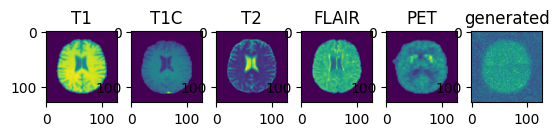

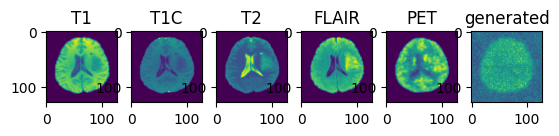

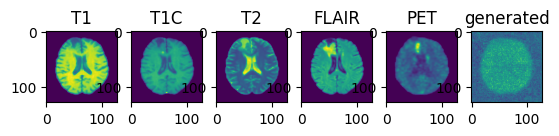

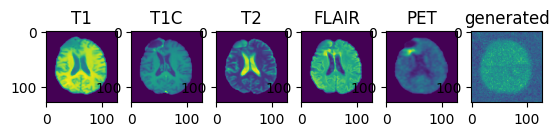

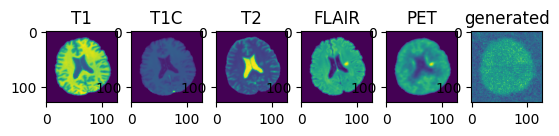

validation avg MS-SSIM: 0.3668 , train avg MS-SSIM: 0.3798
----------
epoch 81/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:27<15:59, 87.26s/it]

Epoch :  17%|██████                              | 2/12 [01:30<06:18, 37.89s/it]

Epoch :  25%|█████████                           | 3/12 [01:33<03:18, 22.11s/it]

Epoch :  33%|████████████                        | 4/12 [01:37<01:57, 14.72s/it]

Epoch :  42%|███████████████                     | 5/12 [01:40<01:14, 10.64s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:44<00:48,  8.17s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:47<00:32,  6.59s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:51<00:22,  5.72s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:54<00:15,  5.03s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:58<00:09,  4.53s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [02:01<00:04,  4.17s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [02:03<00:00,  3.54s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [02:06<00:00, 10.56s/it]

----------
epoch 82/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:28<16:15, 88.65s/it]

Epoch :  17%|██████                              | 2/12 [01:31<06:24, 38.46s/it]

Epoch :  25%|█████████                           | 3/12 [01:37<03:29, 23.22s/it]

Epoch :  33%|████████████                        | 4/12 [01:40<02:03, 15.42s/it]

Epoch :  42%|███████████████                     | 5/12 [01:43<01:17, 11.06s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:47<00:50,  8.43s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:50<00:33,  6.75s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:53<00:22,  5.63s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:57<00:14,  4.90s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [02:00<00:08,  4.45s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [02:03<00:04,  4.08s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [02:06<00:00,  3.57s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [02:09<00:00, 10.79s/it]

----------
epoch 83/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:22<15:04, 82.27s/it]

Epoch :  17%|██████                              | 2/12 [01:25<05:58, 35.83s/it]

Epoch :  25%|█████████                           | 3/12 [01:28<03:08, 20.99s/it]

Epoch :  33%|████████████                        | 4/12 [01:32<01:51, 13.97s/it]

Epoch :  42%|███████████████                     | 5/12 [01:35<01:10, 10.12s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:38<00:47,  7.84s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:42<00:31,  6.35s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:45<00:21,  5.48s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:49<00:14,  4.80s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:52<00:08,  4.30s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:55<00:03,  3.97s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:57<00:00,  3.38s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [02:00<00:00, 10.04s/it]

----------
epoch 84/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:21<14:51, 81.08s/it]

Epoch :  17%|██████                              | 2/12 [01:24<05:54, 35.41s/it]

Epoch :  25%|█████████                           | 3/12 [01:28<03:08, 20.94s/it]

Epoch :  33%|████████████                        | 4/12 [01:31<01:51, 13.94s/it]

Epoch :  42%|███████████████                     | 5/12 [01:34<01:10, 10.10s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:37<00:46,  7.77s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:41<00:31,  6.30s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:44<00:21,  5.34s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:47<00:14,  4.70s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:51<00:08,  4.25s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:54<00:04,  4.07s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:56<00:00,  3.47s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:59<00:00,  9.99s/it]

----------
epoch 85/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:23<15:18, 83.51s/it]

Epoch :  17%|██████                              | 2/12 [01:26<06:02, 36.29s/it]

Epoch :  25%|█████████                           | 3/12 [01:30<03:11, 21.22s/it]

Epoch :  33%|████████████                        | 4/12 [01:33<01:53, 14.16s/it]

Epoch :  42%|███████████████                     | 5/12 [01:36<01:11, 10.26s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:40<00:48,  8.03s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:43<00:32,  6.46s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:47<00:21,  5.48s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:50<00:14,  4.77s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:53<00:08,  4.30s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:56<00:03,  3.99s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:58<00:00,  3.38s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [02:01<00:00, 10.15s/it]

----------
epoch 86/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:21<14:55, 81.45s/it]

Epoch :  17%|██████                              | 2/12 [01:25<05:57, 35.72s/it]

Epoch :  25%|█████████                           | 3/12 [01:28<03:07, 20.86s/it]

Epoch :  33%|████████████                        | 4/12 [01:31<01:51, 13.98s/it]

Epoch :  42%|███████████████                     | 5/12 [01:35<01:11, 10.17s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:38<00:46,  7.82s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:41<00:31,  6.33s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:44<00:21,  5.35s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:48<00:14,  4.69s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:51<00:08,  4.35s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:55<00:04,  4.00s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:57<00:00,  3.40s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [02:00<00:00, 10.03s/it]

----------
epoch 87/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:22<15:03, 82.18s/it]

Epoch :  17%|██████                              | 2/12 [01:25<05:57, 35.78s/it]

Epoch :  25%|█████████                           | 3/12 [01:28<03:08, 20.93s/it]

Epoch :  33%|████████████                        | 4/12 [01:31<01:51, 13.95s/it]

Epoch :  42%|███████████████                     | 5/12 [01:35<01:10, 10.10s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:38<00:47,  7.92s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:42<00:31,  6.39s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:45<00:21,  5.39s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:48<00:14,  4.73s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:51<00:08,  4.26s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:55<00:03,  3.95s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:57<00:00,  3.38s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [02:00<00:00, 10.05s/it]

----------
epoch 88/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:23<15:19, 83.55s/it]

Epoch :  17%|██████                              | 2/12 [01:26<06:02, 36.28s/it]

Epoch :  25%|█████████                           | 3/12 [01:29<03:10, 21.16s/it]

Epoch :  33%|████████████                        | 4/12 [01:33<01:52, 14.09s/it]

Epoch :  42%|███████████████                     | 5/12 [01:36<01:11, 10.17s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:39<00:46,  7.82s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:42<00:31,  6.32s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:46<00:21,  5.34s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:49<00:14,  4.77s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:52<00:08,  4.29s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:56<00:03,  3.98s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:58<00:00,  3.39s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [02:01<00:00, 10.11s/it]

----------
epoch 89/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:20<14:45, 80.50s/it]

Epoch :  17%|██████                              | 2/12 [01:23<05:51, 35.11s/it]

Epoch :  25%|█████████                           | 3/12 [01:27<03:05, 20.57s/it]

Epoch :  33%|████████████                        | 4/12 [01:30<01:51, 13.92s/it]

Epoch :  42%|███████████████                     | 5/12 [01:34<01:10, 10.09s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:37<00:46,  7.78s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:40<00:31,  6.31s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:43<00:21,  5.33s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:47<00:14,  4.72s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:50<00:08,  4.27s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:53<00:03,  3.96s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:56<00:00,  3.47s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:59<00:00,  9.94s/it]

----------
epoch 90/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:22<15:04, 82.23s/it]

Epoch :  17%|██████                              | 2/12 [01:25<05:57, 35.78s/it]

Epoch :  25%|█████████                           | 3/12 [01:28<03:08, 20.92s/it]

Epoch :  33%|████████████                        | 4/12 [01:31<01:51, 13.94s/it]

Epoch :  42%|███████████████                     | 5/12 [01:35<01:10, 10.10s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:38<00:46,  7.78s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:42<00:32,  6.44s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:45<00:21,  5.42s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:48<00:14,  4.73s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:51<00:08,  4.27s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:55<00:03,  3.97s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:57<00:00,  3.39s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [02:00<00:00, 10.03s/it]

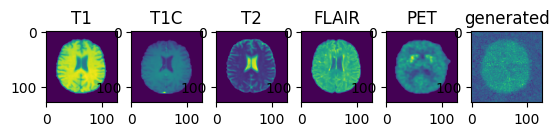

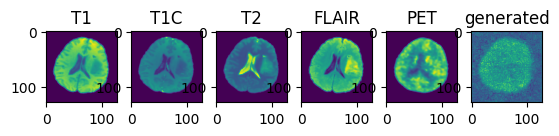

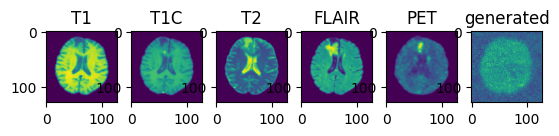

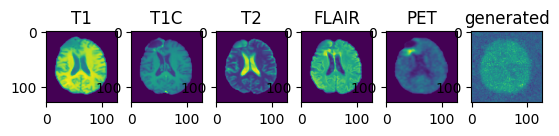

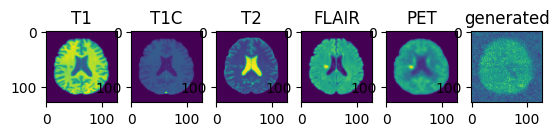

validation avg MS-SSIM: 0.3748 , train avg MS-SSIM: 0.3882
----------
epoch 91/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:22<15:04, 82.21s/it]

Epoch :  17%|██████                              | 2/12 [01:25<05:57, 35.77s/it]

Epoch :  25%|█████████                           | 3/12 [01:28<03:08, 20.90s/it]

Epoch :  33%|████████████                        | 4/12 [01:31<01:51, 13.94s/it]

Epoch :  42%|███████████████                     | 5/12 [01:35<01:11, 10.25s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:38<00:47,  7.85s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:42<00:31,  6.38s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:45<00:21,  5.36s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:48<00:14,  4.68s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:51<00:08,  4.24s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:55<00:03,  3.94s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:57<00:00,  3.39s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [02:00<00:00, 10.02s/it]

----------
epoch 92/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:22<15:10, 82.73s/it]

Epoch :  17%|██████                              | 2/12 [01:25<05:59, 35.97s/it]

Epoch :  25%|█████████                           | 3/12 [01:29<03:09, 21.02s/it]

Epoch :  33%|████████████                        | 4/12 [01:32<01:52, 14.03s/it]

Epoch :  42%|███████████████                     | 5/12 [01:35<01:10, 10.13s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:38<00:46,  7.77s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:42<00:31,  6.30s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:45<00:21,  5.34s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:48<00:14,  4.68s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:51<00:08,  4.24s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:55<00:03,  3.94s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:57<00:00,  3.38s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [02:00<00:00, 10.01s/it]

----------
epoch 93/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:33<17:07, 93.44s/it]

Epoch :  17%|██████                              | 2/12 [01:36<06:43, 40.38s/it]

Epoch :  25%|█████████                           | 3/12 [01:40<03:32, 23.56s/it]

Epoch :  33%|████████████                        | 4/12 [01:43<02:04, 15.56s/it]

Epoch :  42%|███████████████                     | 5/12 [01:46<01:17, 11.11s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:50<00:50,  8.45s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:53<00:33,  6.77s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:56<00:22,  5.70s/it]

Epoch :  75%|███████████████████████████         | 9/12 [02:00<00:14,  4.95s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [02:03<00:08,  4.40s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [02:06<00:04,  4.05s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [02:08<00:00,  3.43s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [02:11<00:00, 10.99s/it]

----------
epoch 94/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:23<15:15, 83.20s/it]

Epoch :  17%|██████                              | 2/12 [01:26<06:02, 36.20s/it]

Epoch :  25%|█████████                           | 3/12 [01:29<03:11, 21.25s/it]

Epoch :  33%|████████████                        | 4/12 [01:33<01:52, 14.12s/it]

Epoch :  42%|███████████████                     | 5/12 [01:36<01:11, 10.20s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:39<00:47,  7.84s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:43<00:32,  6.47s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:46<00:21,  5.46s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:49<00:14,  4.77s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:53<00:08,  4.30s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:56<00:03,  3.98s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:58<00:00,  3.39s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [02:01<00:00, 10.13s/it]

----------
epoch 95/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:22<15:04, 82.22s/it]

Epoch :  17%|██████                              | 2/12 [01:26<06:00, 36.09s/it]

Epoch :  25%|█████████                           | 3/12 [01:29<03:09, 21.08s/it]

Epoch :  33%|████████████                        | 4/12 [01:32<01:52, 14.03s/it]

Epoch :  42%|███████████████                     | 5/12 [01:35<01:11, 10.15s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:38<00:46,  7.80s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:42<00:31,  6.32s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:45<00:21,  5.39s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:48<00:14,  4.71s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:52<00:08,  4.37s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:55<00:04,  4.04s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:57<00:00,  3.44s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [02:01<00:00, 10.09s/it]

----------
epoch 96/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:22<15:04, 82.25s/it]

Epoch :  17%|██████                              | 2/12 [01:25<05:57, 35.76s/it]

Epoch :  25%|█████████                           | 3/12 [01:28<03:08, 20.90s/it]

Epoch :  33%|████████████                        | 4/12 [01:31<01:51, 13.94s/it]

Epoch :  42%|███████████████                     | 5/12 [01:35<01:11, 10.25s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:38<00:47,  7.88s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:42<00:31,  6.36s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:45<00:21,  5.38s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:48<00:14,  4.73s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:51<00:08,  4.26s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:55<00:03,  3.95s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:57<00:00,  3.35s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [02:00<00:00, 10.02s/it]

----------
epoch 97/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:20<14:49, 80.82s/it]

Epoch :  17%|██████                              | 2/12 [01:24<05:52, 35.21s/it]

Epoch :  25%|█████████                           | 3/12 [01:27<03:05, 20.62s/it]

Epoch :  33%|████████████                        | 4/12 [01:30<01:49, 13.75s/it]

Epoch :  42%|███████████████                     | 5/12 [01:33<01:09,  9.97s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:37<00:46,  7.70s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:40<00:31,  6.25s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:43<00:21,  5.29s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:47<00:14,  4.76s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:50<00:08,  4.30s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:53<00:03,  3.99s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:55<00:00,  3.39s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:59<00:00,  9.92s/it]

----------
epoch 98/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:22<15:07, 82.46s/it]

Epoch :  17%|██████                              | 2/12 [01:25<05:58, 35.85s/it]

Epoch :  25%|█████████                           | 3/12 [01:29<03:09, 21.01s/it]

Epoch :  33%|████████████                        | 4/12 [01:32<01:53, 14.18s/it]

Epoch :  42%|███████████████                     | 5/12 [01:35<01:11, 10.23s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:39<00:46,  7.82s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:42<00:31,  6.37s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:45<00:21,  5.36s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:48<00:14,  4.68s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:52<00:08,  4.24s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:55<00:03,  3.93s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:57<00:00,  3.45s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [02:00<00:00, 10.06s/it]

----------
epoch 99/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:21<14:59, 81.75s/it]

Epoch :  17%|██████                              | 2/12 [01:25<05:56, 35.61s/it]

Epoch :  25%|█████████                           | 3/12 [01:28<03:07, 20.84s/it]

Epoch :  33%|████████████                        | 4/12 [01:31<01:51, 13.93s/it]

Epoch :  42%|███████████████                     | 5/12 [01:34<01:10, 10.08s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:38<00:46,  7.75s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:41<00:31,  6.38s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:44<00:21,  5.39s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:48<00:14,  4.71s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:51<00:08,  4.25s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:54<00:03,  3.96s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:56<00:00,  3.36s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [02:00<00:00, 10.01s/it]

----------
epoch 100/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:22<15:11, 82.90s/it]

Epoch :  17%|██████                              | 2/12 [01:26<06:00, 36.04s/it]

Epoch :  25%|█████████                           | 3/12 [01:29<03:11, 21.24s/it]

Epoch :  33%|████████████                        | 4/12 [01:33<01:53, 14.15s/it]

Epoch :  42%|███████████████                     | 5/12 [01:36<01:11, 10.23s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:39<00:47,  7.86s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:42<00:31,  6.33s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:46<00:21,  5.35s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:49<00:14,  4.71s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:52<00:08,  4.27s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:56<00:04,  4.06s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:58<00:00,  3.46s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [02:01<00:00, 10.11s/it]

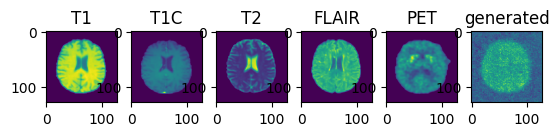

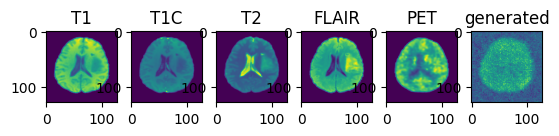

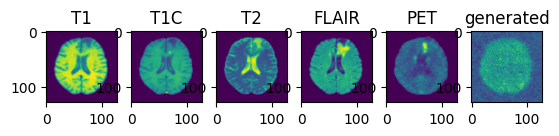

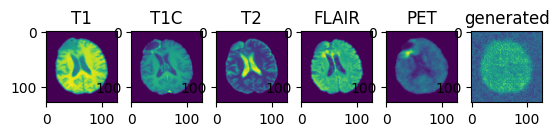

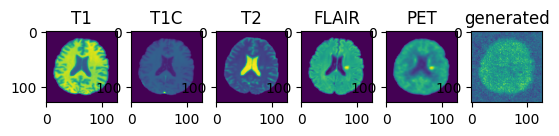

validation avg MS-SSIM: 0.3694 , train avg MS-SSIM: 0.3832
----------
epoch 101/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:34<17:17, 94.35s/it]

Epoch :  17%|██████                              | 2/12 [01:38<06:50, 41.06s/it]

Epoch :  25%|█████████                           | 3/12 [01:41<03:34, 23.79s/it]

Epoch :  33%|████████████                        | 4/12 [01:44<02:05, 15.68s/it]

Epoch :  42%|███████████████                     | 5/12 [01:47<01:18, 11.19s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:51<00:50,  8.49s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:54<00:33,  6.78s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:57<00:22,  5.63s/it]

Epoch :  75%|███████████████████████████         | 9/12 [02:00<00:14,  4.97s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [02:04<00:08,  4.45s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [02:07<00:04,  4.07s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [02:09<00:00,  3.46s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [02:12<00:00, 11.06s/it]

----------
epoch 102/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:20<14:41, 80.17s/it]

Epoch :  17%|██████                              | 2/12 [01:23<05:49, 34.92s/it]

Epoch :  25%|█████████                           | 3/12 [01:26<03:04, 20.45s/it]

Epoch :  33%|████████████                        | 4/12 [01:29<01:49, 13.65s/it]

Epoch :  42%|███████████████                     | 5/12 [01:33<01:10, 10.03s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:36<00:46,  7.72s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:40<00:31,  6.28s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:43<00:21,  5.32s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:46<00:13,  4.66s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:49<00:08,  4.23s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:52<00:03,  3.92s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:55<00:00,  3.34s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:58<00:00,  9.84s/it]

----------
epoch 103/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:20<14:45, 80.54s/it]

Epoch :  17%|██████                              | 2/12 [01:23<05:51, 35.12s/it]

Epoch :  25%|█████████                           | 3/12 [01:27<03:05, 20.56s/it]

Epoch :  33%|████████████                        | 4/12 [01:30<01:49, 13.72s/it]

Epoch :  42%|███████████████                     | 5/12 [01:33<01:09,  9.94s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:36<00:46,  7.67s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:40<00:31,  6.23s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:43<00:21,  5.41s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:46<00:14,  4.72s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:50<00:08,  4.26s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:53<00:03,  3.94s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:55<00:00,  3.36s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:58<00:00,  9.85s/it]

----------
epoch 104/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:18<14:18, 78.08s/it]

Epoch :  17%|██████                              | 2/12 [01:21<05:40, 34.10s/it]

Epoch :  25%|█████████                           | 3/12 [01:24<03:00, 20.02s/it]

Epoch :  33%|████████████                        | 4/12 [01:28<01:48, 13.54s/it]

Epoch :  42%|███████████████                     | 5/12 [01:31<01:09,  9.86s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:34<00:45,  7.62s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:38<00:30,  6.18s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:41<00:20,  5.23s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:44<00:13,  4.61s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:47<00:08,  4.19s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:51<00:03,  3.90s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:53<00:00,  3.42s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:56<00:00,  9.69s/it]

----------
epoch 105/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:20<14:43, 80.30s/it]

Epoch :  17%|██████                              | 2/12 [01:23<05:49, 35.00s/it]

Epoch :  25%|█████████                           | 3/12 [01:26<03:04, 20.52s/it]

Epoch :  33%|████████████                        | 4/12 [01:30<01:49, 13.70s/it]

Epoch :  42%|███████████████                     | 5/12 [01:33<01:09,  9.95s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:36<00:46,  7.68s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:40<00:31,  6.35s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:43<00:21,  5.36s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:46<00:14,  4.70s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:50<00:08,  4.25s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:53<00:03,  3.93s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:55<00:00,  3.39s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:58<00:00,  9.88s/it]

----------
epoch 106/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:33<17:03, 93.08s/it]

Epoch :  17%|██████                              | 2/12 [01:36<06:42, 40.29s/it]

Epoch :  25%|█████████                           | 3/12 [01:40<03:31, 23.55s/it]

Epoch :  33%|████████████                        | 4/12 [01:43<02:04, 15.53s/it]

Epoch :  42%|███████████████                     | 5/12 [01:46<01:17, 11.11s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:49<00:50,  8.45s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:53<00:33,  6.73s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:56<00:22,  5.63s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:59<00:14,  4.88s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [02:02<00:08,  4.38s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [02:06<00:04,  4.05s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [02:08<00:00,  3.56s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [02:11<00:00, 10.98s/it]

----------
epoch 107/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:21<15:00, 81.89s/it]

Epoch :  17%|██████                              | 2/12 [01:25<05:56, 35.67s/it]

Epoch :  25%|█████████                           | 3/12 [01:28<03:07, 20.88s/it]

Epoch :  33%|████████████                        | 4/12 [01:31<01:51, 13.92s/it]

Epoch :  42%|███████████████                     | 5/12 [01:34<01:10, 10.06s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:38<00:47,  7.91s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:41<00:31,  6.37s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:45<00:21,  5.38s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:48<00:14,  4.73s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:51<00:08,  4.27s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:54<00:03,  3.98s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:57<00:00,  3.39s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [02:00<00:00, 10.03s/it]

----------
epoch 108/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:17<14:07, 77.09s/it]

Epoch :  17%|██████                              | 2/12 [01:20<05:38, 33.84s/it]

Epoch :  25%|█████████                           | 3/12 [01:23<02:58, 19.84s/it]

Epoch :  33%|████████████                        | 4/12 [01:27<01:46, 13.26s/it]

Epoch :  42%|███████████████                     | 5/12 [01:30<01:07,  9.63s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:33<00:44,  7.44s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:36<00:30,  6.06s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:39<00:20,  5.15s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:43<00:13,  4.54s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:46<00:08,  4.11s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:49<00:03,  3.83s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:51<00:00,  3.27s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:54<00:00,  9.51s/it]

----------
epoch 109/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:14<13:42, 74.80s/it]

Epoch :  17%|██████                              | 2/12 [01:18<05:27, 32.70s/it]

Epoch :  25%|█████████                           | 3/12 [01:21<02:53, 19.23s/it]

Epoch :  33%|████████████                        | 4/12 [01:24<01:43, 12.89s/it]

Epoch :  42%|███████████████                     | 5/12 [01:27<01:06,  9.54s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:31<00:44,  7.39s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:34<00:30,  6.02s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:37<00:20,  5.12s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:40<00:13,  4.52s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:43<00:08,  4.10s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:47<00:03,  3.81s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:49<00:00,  3.26s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:52<00:00,  9.34s/it]

----------
epoch 110/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:16<14:00, 76.43s/it]

Epoch :  17%|██████                              | 2/12 [01:19<05:33, 33.35s/it]

Epoch :  25%|█████████                           | 3/12 [01:22<02:56, 19.58s/it]

Epoch :  33%|████████████                        | 4/12 [01:25<01:44, 13.10s/it]

Epoch :  42%|███████████████                     | 5/12 [01:29<01:06,  9.54s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:32<00:44,  7.38s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:35<00:29,  5.99s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:38<00:20,  5.09s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:41<00:13,  4.49s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:45<00:08,  4.18s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:48<00:03,  3.87s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:50<00:00,  3.29s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:53<00:00,  9.45s/it]

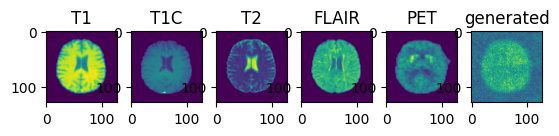

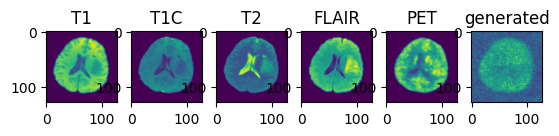

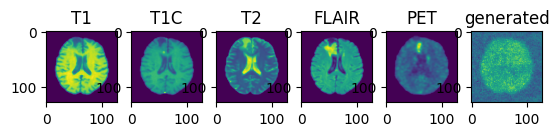

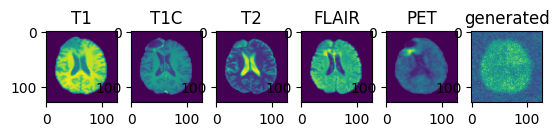

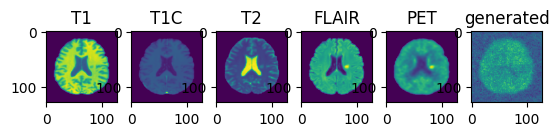

validation avg MS-SSIM: 0.3796 , train avg MS-SSIM: 0.3921
----------
epoch 111/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:09<12:40, 69.10s/it]

Epoch :  17%|██████                              | 2/12 [01:12<05:04, 30.45s/it]

Epoch :  25%|█████████                           | 3/12 [01:15<02:41, 17.98s/it]

Epoch :  33%|████████████                        | 4/12 [01:18<01:36, 12.11s/it]

Epoch :  42%|███████████████                     | 5/12 [01:21<01:02,  8.87s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:25<00:41,  6.93s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:28<00:28,  5.69s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:31<00:19,  4.99s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:34<00:13,  4.42s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:37<00:08,  4.03s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:41<00:03,  3.76s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:43<00:00,  3.21s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:45<00:00,  8.82s/it]

----------
epoch 112/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:11<13:08, 71.71s/it]

Epoch :  17%|██████                              | 2/12 [01:14<05:14, 31.42s/it]

Epoch :  25%|█████████                           | 3/12 [01:18<02:48, 18.69s/it]

Epoch :  33%|████████████                        | 4/12 [01:21<01:40, 12.55s/it]

Epoch :  42%|███████████████                     | 5/12 [01:24<01:04,  9.16s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:27<00:42,  7.13s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:31<00:29,  5.83s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:34<00:19,  4.98s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:37<00:13,  4.41s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:40<00:08,  4.02s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:43<00:03,  3.76s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:45<00:00,  3.21s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:48<00:00,  9.02s/it]

----------
epoch 113/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:10<12:54, 70.43s/it]

Epoch :  17%|██████                              | 2/12 [01:13<05:08, 30.88s/it]

Epoch :  25%|█████████                           | 3/12 [01:16<02:44, 18.23s/it]

Epoch :  33%|████████████                        | 4/12 [01:19<01:38, 12.28s/it]

Epoch :  42%|███████████████                     | 5/12 [01:23<01:02,  8.98s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:26<00:41,  7.00s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:29<00:29,  5.84s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:32<00:19,  4.99s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:36<00:13,  4.41s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:39<00:08,  4.02s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:42<00:03,  3.75s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:44<00:00,  3.21s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:46<00:00,  8.90s/it]

----------
epoch 114/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:12<13:16, 72.40s/it]

Epoch :  17%|██████                              | 2/12 [01:15<05:19, 31.91s/it]

Epoch :  25%|█████████                           | 3/12 [01:19<02:49, 18.78s/it]

Epoch :  33%|████████████                        | 4/12 [01:22<01:40, 12.61s/it]

Epoch :  42%|███████████████                     | 5/12 [01:25<01:04,  9.20s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:28<00:42,  7.14s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:31<00:29,  5.83s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:34<00:19,  4.98s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:38<00:13,  4.41s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:41<00:08,  4.03s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:44<00:03,  3.86s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:46<00:00,  3.29s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:48<00:00,  9.07s/it]

----------
epoch 115/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:23<15:22, 83.90s/it]

Epoch :  17%|██████                              | 2/12 [01:27<06:04, 36.40s/it]

Epoch :  25%|█████████                           | 3/12 [01:30<03:10, 21.22s/it]

Epoch :  33%|████████████                        | 4/12 [01:33<01:52, 14.08s/it]

Epoch :  42%|███████████████                     | 5/12 [01:36<01:10, 10.13s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:39<00:47,  7.88s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:43<00:31,  6.33s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:46<00:21,  5.32s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:49<00:13,  4.64s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:52<00:08,  4.17s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:55<00:03,  3.86s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:57<00:00,  3.27s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [02:00<00:00, 10.04s/it]

----------
epoch 116/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:10<12:55, 70.50s/it]

Epoch :  17%|██████                              | 2/12 [01:13<05:10, 31.07s/it]

Epoch :  25%|█████████                           | 3/12 [01:17<02:45, 18.33s/it]

Epoch :  33%|████████████                        | 4/12 [01:20<01:38, 12.33s/it]

Epoch :  42%|███████████████                     | 5/12 [01:23<01:03,  9.01s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:26<00:42,  7.02s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:29<00:28,  5.76s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:32<00:19,  4.93s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:36<00:13,  4.46s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:39<00:08,  4.05s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:42<00:03,  3.77s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:44<00:00,  3.21s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:47<00:00,  8.97s/it]

----------
epoch 117/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:10<12:58, 70.76s/it]

Epoch :  17%|██████                              | 2/12 [01:13<05:09, 30.99s/it]

Epoch :  25%|█████████                           | 3/12 [01:17<02:44, 18.26s/it]

Epoch :  33%|████████████                        | 4/12 [01:20<01:38, 12.28s/it]

Epoch :  42%|███████████████                     | 5/12 [01:23<01:03,  9.11s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:26<00:42,  7.08s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:29<00:28,  5.78s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:32<00:19,  4.94s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:36<00:13,  4.37s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:39<00:07,  3.99s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:42<00:03,  3.73s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:44<00:00,  3.19s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:46<00:00,  8.91s/it]

----------
epoch 118/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:14<13:35, 74.14s/it]

Epoch :  17%|██████                              | 2/12 [01:17<05:23, 32.39s/it]

Epoch :  25%|█████████                           | 3/12 [01:20<02:51, 19.05s/it]

Epoch :  33%|████████████                        | 4/12 [01:23<01:42, 12.78s/it]

Epoch :  42%|███████████████                     | 5/12 [01:26<01:05,  9.30s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:29<00:43,  7.20s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:33<00:29,  5.87s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:36<00:20,  5.00s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:39<00:13,  4.54s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:42<00:08,  4.10s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:45<00:03,  3.81s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:47<00:00,  3.24s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:50<00:00,  9.23s/it]

----------
epoch 119/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:10<12:58, 70.79s/it]

Epoch :  17%|██████                              | 2/12 [01:13<05:10, 31.03s/it]

Epoch :  25%|█████████                           | 3/12 [01:17<02:45, 18.34s/it]

Epoch :  33%|████████████                        | 4/12 [01:20<01:38, 12.36s/it]

Epoch :  42%|███████████████                     | 5/12 [01:24<01:04,  9.19s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:27<00:42,  7.14s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:30<00:29,  5.86s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:33<00:20,  5.01s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:36<00:13,  4.44s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:39<00:08,  4.05s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:43<00:03,  3.78s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:45<00:00,  3.23s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:47<00:00,  8.97s/it]

----------
epoch 120/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:12<13:18, 72.63s/it]

Epoch :  17%|██████                              | 2/12 [01:15<05:17, 31.78s/it]

Epoch :  25%|█████████                           | 3/12 [01:18<02:48, 18.70s/it]

Epoch :  33%|████████████                        | 4/12 [01:22<01:40, 12.56s/it]

Epoch :  42%|███████████████                     | 5/12 [01:25<01:04,  9.17s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:28<00:42,  7.13s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:31<00:29,  5.83s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:34<00:20,  5.01s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:37<00:13,  4.43s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:41<00:08,  4.04s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:44<00:03,  3.77s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:46<00:00,  3.21s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:49<00:00,  9.10s/it]

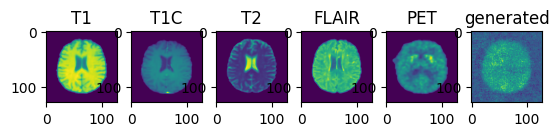

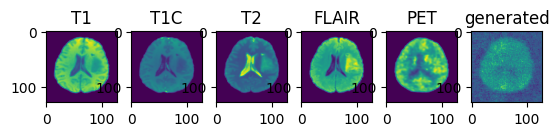

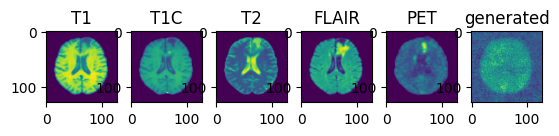

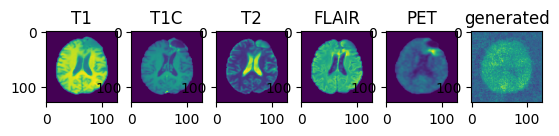

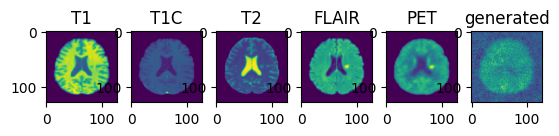

validation avg MS-SSIM: 0.3789 , train avg MS-SSIM: 0.3929
----------
epoch 121/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:11<13:01, 71.07s/it]

Epoch :  17%|██████                              | 2/12 [01:14<05:11, 31.11s/it]

Epoch :  25%|█████████                           | 3/12 [01:17<02:45, 18.35s/it]

Epoch :  33%|████████████                        | 4/12 [01:20<01:38, 12.34s/it]

Epoch :  42%|███████████████                     | 5/12 [01:23<01:03,  9.01s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:26<00:42,  7.01s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:30<00:29,  5.85s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:33<00:19,  4.98s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:36<00:13,  4.40s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:39<00:08,  4.01s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:42<00:03,  3.74s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:44<00:00,  3.20s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:47<00:00,  8.94s/it]

----------
epoch 122/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:12<13:19, 72.65s/it]

Epoch :  17%|██████                              | 2/12 [01:15<05:17, 31.77s/it]

Epoch :  25%|█████████                           | 3/12 [01:19<02:49, 18.85s/it]

Epoch :  33%|████████████                        | 4/12 [01:22<01:41, 12.64s/it]

Epoch :  42%|███████████████                     | 5/12 [01:25<01:04,  9.21s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:28<00:42,  7.14s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:31<00:29,  5.82s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:34<00:19,  4.96s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:37<00:13,  4.39s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:41<00:08,  4.08s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:44<00:03,  3.79s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:46<00:00,  3.22s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:48<00:00,  9.07s/it]

----------
epoch 123/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:12<13:18, 72.62s/it]

Epoch :  17%|██████                              | 2/12 [01:15<05:17, 31.74s/it]

Epoch :  25%|█████████                           | 3/12 [01:18<02:48, 18.68s/it]

Epoch :  33%|████████████                        | 4/12 [01:22<01:40, 12.55s/it]

Epoch :  42%|███████████████                     | 5/12 [01:25<01:04,  9.16s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:28<00:43,  7.22s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:31<00:29,  5.88s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:34<00:20,  5.01s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:38<00:13,  4.42s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:41<00:08,  4.02s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:44<00:03,  3.74s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:46<00:00,  3.19s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:48<00:00,  9.07s/it]

----------
epoch 124/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:15<13:51, 75.63s/it]

Epoch :  17%|██████                              | 2/12 [01:18<05:29, 33.00s/it]

Epoch :  25%|█████████                           | 3/12 [01:21<02:54, 19.37s/it]

Epoch :  33%|████████████                        | 4/12 [01:25<01:43, 12.96s/it]

Epoch :  42%|███████████████                     | 5/12 [01:28<01:05,  9.41s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:31<00:43,  7.28s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:34<00:29,  5.93s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:37<00:20,  5.04s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:41<00:13,  4.54s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:44<00:08,  4.11s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:47<00:03,  3.82s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:49<00:00,  3.24s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:53<00:00,  9.45s/it]

----------
epoch 125/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:13<13:23, 73.08s/it]

Epoch :  17%|██████                              | 2/12 [01:16<05:19, 31.96s/it]

Epoch :  25%|█████████                           | 3/12 [01:19<02:49, 18.83s/it]

Epoch :  33%|████████████                        | 4/12 [01:22<01:41, 12.67s/it]

Epoch :  42%|███████████████                     | 5/12 [01:26<01:05,  9.41s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:29<00:43,  7.28s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:32<00:29,  5.92s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:35<00:20,  5.03s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:38<00:13,  4.44s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:41<00:08,  4.04s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:45<00:03,  3.75s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:47<00:00,  3.28s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:49<00:00,  9.14s/it]

----------
epoch 126/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:12<13:12, 72.01s/it]

Epoch :  17%|██████                              | 2/12 [01:15<05:15, 31.52s/it]

Epoch :  25%|█████████                           | 3/12 [01:18<02:47, 18.57s/it]

Epoch :  33%|████████████                        | 4/12 [01:21<01:40, 12.50s/it]

Epoch :  42%|███████████████                     | 5/12 [01:24<01:04,  9.15s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:27<00:42,  7.12s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:31<00:29,  5.83s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:34<00:20,  5.09s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:37<00:13,  4.50s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:40<00:08,  4.08s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:44<00:03,  3.80s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:46<00:00,  3.25s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:48<00:00,  9.05s/it]

----------
epoch 127/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:12<13:18, 72.58s/it]

Epoch :  17%|██████                              | 2/12 [01:15<05:17, 31.79s/it]

Epoch :  25%|█████████                           | 3/12 [01:19<02:48, 18.77s/it]

Epoch :  33%|████████████                        | 4/12 [01:22<01:42, 12.80s/it]

Epoch :  42%|███████████████                     | 5/12 [01:25<01:05,  9.35s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:29<00:43,  7.27s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:32<00:29,  5.96s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:35<00:20,  5.07s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:38<00:13,  4.48s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:41<00:08,  4.08s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:45<00:03,  3.82s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:47<00:00,  3.37s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:50<00:00,  9.19s/it]

----------
epoch 128/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:09<12:42, 69.34s/it]

Epoch :  17%|██████                              | 2/12 [01:12<05:04, 30.43s/it]

Epoch :  25%|█████████                           | 3/12 [01:15<02:41, 17.99s/it]

Epoch :  33%|████████████                        | 4/12 [01:18<01:37, 12.13s/it]

Epoch :  42%|███████████████                     | 5/12 [01:22<01:02,  8.90s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:25<00:41,  6.95s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:28<00:29,  5.83s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:31<00:19,  4.98s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:35<00:13,  4.41s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:38<00:08,  4.02s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:41<00:03,  3.75s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:43<00:00,  3.20s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:45<00:00,  8.82s/it]

----------
epoch 129/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:12<13:18, 72.62s/it]

Epoch :  17%|██████                              | 2/12 [01:17<05:27, 32.76s/it]

Epoch :  25%|█████████                           | 3/12 [01:20<02:53, 19.30s/it]

Epoch :  33%|████████████                        | 4/12 [01:23<01:43, 12.95s/it]

Epoch :  42%|███████████████                     | 5/12 [01:27<01:05,  9.43s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:30<00:43,  7.31s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:33<00:29,  5.98s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:36<00:20,  5.11s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:40<00:13,  4.64s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:43<00:08,  4.21s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:46<00:03,  3.90s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:48<00:00,  3.33s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:51<00:00,  9.32s/it]

----------
epoch 130/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:22<15:09, 82.69s/it]

Epoch :  17%|██████                              | 2/12 [01:25<05:59, 35.95s/it]

Epoch :  25%|█████████                           | 3/12 [01:29<03:09, 21.00s/it]

Epoch :  33%|████████████                        | 4/12 [01:32<01:51, 13.97s/it]

Epoch :  42%|███████████████                     | 5/12 [01:35<01:11, 10.20s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:39<00:46,  7.82s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:42<00:31,  6.31s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:45<00:21,  5.31s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:48<00:13,  4.66s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:51<00:08,  4.21s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:55<00:03,  3.90s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:57<00:00,  3.31s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:59<00:00,  9.96s/it]

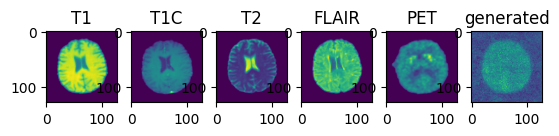

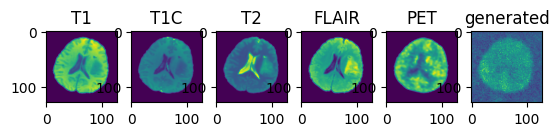

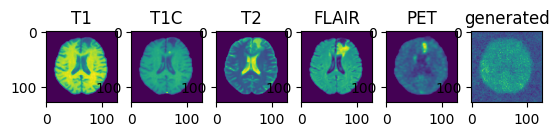

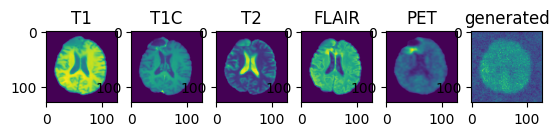

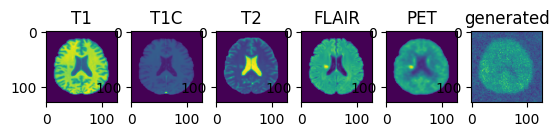

validation avg MS-SSIM: 0.3841 , train avg MS-SSIM: 0.3988
----------
epoch 131/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:19<14:31, 79.23s/it]

Epoch :  17%|██████                              | 2/12 [01:22<05:45, 34.50s/it]

Epoch :  25%|█████████                           | 3/12 [01:25<03:01, 20.20s/it]

Epoch :  33%|████████████                        | 4/12 [01:29<01:49, 13.68s/it]

Epoch :  42%|███████████████                     | 5/12 [01:32<01:09,  9.90s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:35<00:45,  7.61s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:38<00:30,  6.14s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:41<00:20,  5.18s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:45<00:13,  4.55s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:48<00:08,  4.12s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:51<00:03,  3.84s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:53<00:00,  3.35s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:56<00:00,  9.71s/it]

----------
epoch 132/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:17<14:10, 77.28s/it]

Epoch :  17%|██████                              | 2/12 [01:20<05:37, 33.71s/it]

Epoch :  25%|█████████                           | 3/12 [01:23<02:58, 19.78s/it]

Epoch :  33%|████████████                        | 4/12 [01:26<01:45, 13.23s/it]

Epoch :  42%|███████████████                     | 5/12 [01:30<01:07,  9.60s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:33<00:44,  7.42s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:36<00:30,  6.17s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:40<00:20,  5.22s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:43<00:13,  4.59s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:46<00:08,  4.15s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:49<00:03,  3.86s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:51<00:00,  3.29s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:54<00:00,  9.56s/it]

----------
epoch 133/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:10<12:58, 70.79s/it]

Epoch :  17%|██████                              | 2/12 [01:14<05:10, 31.04s/it]

Epoch :  25%|█████████                           | 3/12 [01:17<02:46, 18.50s/it]

Epoch :  33%|████████████                        | 4/12 [01:20<01:39, 12.45s/it]

Epoch :  42%|███████████████                     | 5/12 [01:23<01:03,  9.10s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:27<00:42,  7.09s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:30<00:29,  5.82s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:33<00:19,  4.98s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:36<00:13,  4.41s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:39<00:08,  4.04s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:43<00:03,  3.87s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:45<00:00,  3.29s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:48<00:00,  9.01s/it]

----------
epoch 134/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:12<13:16, 72.37s/it]

Epoch :  17%|██████                              | 2/12 [01:15<05:16, 31.67s/it]

Epoch :  25%|█████████                           | 3/12 [01:18<02:47, 18.65s/it]

Epoch :  33%|████████████                        | 4/12 [01:21<01:40, 12.53s/it]

Epoch :  42%|███████████████                     | 5/12 [01:25<01:04,  9.15s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:28<00:43,  7.23s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:31<00:29,  5.89s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:34<00:20,  5.03s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:38<00:13,  4.45s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:41<00:08,  4.05s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:44<00:03,  3.78s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:46<00:00,  3.23s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:48<00:00,  9.08s/it]

----------
epoch 135/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:10<12:52, 70.25s/it]

Epoch :  17%|██████                              | 2/12 [01:13<05:10, 31.00s/it]

Epoch :  25%|█████████                           | 3/12 [01:16<02:44, 18.30s/it]

Epoch :  33%|████████████                        | 4/12 [01:20<01:38, 12.32s/it]

Epoch :  42%|███████████████                     | 5/12 [01:23<01:03,  9.02s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:26<00:42,  7.03s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:29<00:28,  5.77s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:32<00:19,  4.95s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:36<00:13,  4.50s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:39<00:08,  4.09s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:42<00:03,  3.80s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:44<00:00,  3.25s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:47<00:00,  8.96s/it]

----------
epoch 136/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:12<13:15, 72.31s/it]

Epoch :  17%|██████                              | 2/12 [01:15<05:16, 31.64s/it]

Epoch :  25%|█████████                           | 3/12 [01:18<02:47, 18.64s/it]

Epoch :  33%|████████████                        | 4/12 [01:21<01:40, 12.53s/it]

Epoch :  42%|███████████████                     | 5/12 [01:25<01:04,  9.28s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:28<00:43,  7.21s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:31<00:29,  5.89s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:34<00:20,  5.03s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:38<00:13,  4.45s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:41<00:08,  4.06s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:44<00:03,  3.79s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:46<00:00,  3.34s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:49<00:00,  9.11s/it]

----------
epoch 137/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:14<13:38, 74.39s/it]

Epoch :  17%|██████                              | 2/12 [01:17<05:24, 32.50s/it]

Epoch :  25%|█████████                           | 3/12 [01:20<02:51, 19.11s/it]

Epoch :  33%|████████████                        | 4/12 [01:23<01:42, 12.81s/it]

Epoch :  42%|███████████████                     | 5/12 [01:27<01:05,  9.33s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:30<00:43,  7.24s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:33<00:29,  5.91s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:36<00:20,  5.15s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:40<00:13,  4.53s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:43<00:08,  4.11s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:46<00:03,  3.82s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:48<00:00,  3.26s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:51<00:00,  9.26s/it]

----------
epoch 138/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:11<13:01, 71.05s/it]

Epoch :  17%|██████                              | 2/12 [01:14<05:11, 31.11s/it]

Epoch :  25%|█████████                           | 3/12 [01:17<02:46, 18.53s/it]

Epoch :  33%|████████████                        | 4/12 [01:20<01:39, 12.46s/it]

Epoch :  42%|███████████████                     | 5/12 [01:24<01:03,  9.10s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:27<00:42,  7.07s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:30<00:29,  5.80s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:33<00:19,  4.96s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:36<00:13,  4.39s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:39<00:08,  4.01s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:43<00:03,  3.84s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:45<00:00,  3.27s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:48<00:00,  9.00s/it]

----------
epoch 139/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:24<15:34, 84.95s/it]

Epoch :  17%|██████                              | 2/12 [01:28<06:08, 36.86s/it]

Epoch :  25%|█████████                           | 3/12 [01:31<03:13, 21.48s/it]

Epoch :  33%|████████████                        | 4/12 [01:34<01:54, 14.26s/it]

Epoch :  42%|███████████████                     | 5/12 [01:37<01:11, 10.26s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:40<00:47,  7.85s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:44<00:32,  6.43s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:47<00:21,  5.40s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:50<00:14,  4.70s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:53<00:08,  4.22s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:57<00:03,  3.89s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:58<00:00,  3.30s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [02:01<00:00, 10.13s/it]

----------
epoch 140/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:13<13:29, 73.63s/it]

Epoch :  17%|██████                              | 2/12 [01:17<05:24, 32.48s/it]

Epoch :  25%|█████████                           | 3/12 [01:20<02:52, 19.12s/it]

Epoch :  33%|████████████                        | 4/12 [01:23<01:42, 12.86s/it]

Epoch :  42%|███████████████                     | 5/12 [01:27<01:05,  9.40s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:30<00:43,  7.33s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:33<00:29,  5.99s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:36<00:20,  5.09s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:39<00:13,  4.50s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:43<00:08,  4.20s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:46<00:03,  3.90s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:48<00:00,  3.31s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:51<00:00,  9.29s/it]

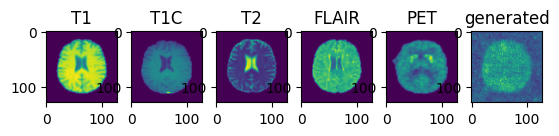

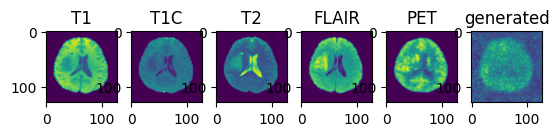

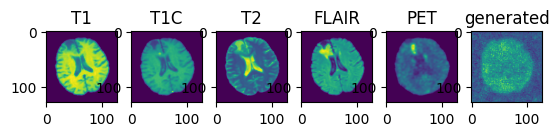

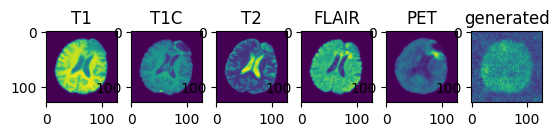

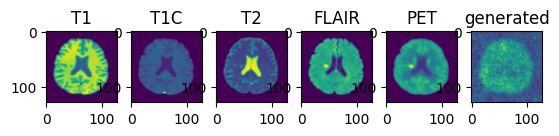

validation avg MS-SSIM: 0.3816 , train avg MS-SSIM: 0.3978
----------
epoch 141/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:14<13:43, 74.90s/it]

Epoch :  17%|██████                              | 2/12 [01:18<05:29, 33.00s/it]

Epoch :  25%|█████████                           | 3/12 [01:21<02:54, 19.39s/it]

Epoch :  33%|████████████                        | 4/12 [01:24<01:43, 13.00s/it]

Epoch :  42%|███████████████                     | 5/12 [01:28<01:06,  9.47s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:31<00:43,  7.33s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:34<00:29,  5.97s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:37<00:20,  5.08s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:40<00:13,  4.49s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:44<00:08,  4.18s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:47<00:03,  3.88s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:49<00:00,  3.30s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:52<00:00,  9.35s/it]

----------
epoch 142/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:11<13:03, 71.18s/it]

Epoch :  17%|██████                              | 2/12 [01:14<05:12, 31.29s/it]

Epoch :  25%|█████████                           | 3/12 [01:17<02:46, 18.50s/it]

Epoch :  33%|████████████                        | 4/12 [01:21<01:40, 12.52s/it]

Epoch :  42%|███████████████                     | 5/12 [01:24<01:04,  9.17s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:27<00:42,  7.14s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:30<00:29,  5.87s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:34<00:20,  5.02s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:37<00:13,  4.45s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:40<00:08,  4.06s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:43<00:03,  3.79s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:45<00:00,  3.24s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:48<00:00,  9.06s/it]

----------
epoch 143/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:13<13:28, 73.51s/it]

Epoch :  17%|██████                              | 2/12 [01:16<05:21, 32.15s/it]

Epoch :  25%|█████████                           | 3/12 [01:19<02:50, 18.93s/it]

Epoch :  33%|████████████                        | 4/12 [01:23<01:41, 12.72s/it]

Epoch :  42%|███████████████                     | 5/12 [01:26<01:04,  9.28s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:29<00:43,  7.21s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:32<00:29,  5.94s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:36<00:20,  5.14s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:39<00:13,  4.54s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:42<00:08,  4.12s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:45<00:03,  3.84s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:47<00:00,  3.27s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:50<00:00,  9.24s/it]

----------
epoch 144/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:13<13:25, 73.26s/it]

Epoch :  17%|██████                              | 2/12 [01:16<05:20, 32.02s/it]

Epoch :  25%|█████████                           | 3/12 [01:19<02:49, 18.85s/it]

Epoch :  33%|████████████                        | 4/12 [01:23<01:42, 12.81s/it]

Epoch :  42%|███████████████                     | 5/12 [01:26<01:05,  9.35s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:29<00:43,  7.25s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:32<00:29,  5.91s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:35<00:20,  5.04s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:39<00:13,  4.46s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:42<00:08,  4.06s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:45<00:03,  3.78s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:47<00:00,  3.33s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:50<00:00,  9.20s/it]

----------
epoch 145/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:12<13:18, 72.55s/it]

Epoch :  17%|██████                              | 2/12 [01:15<05:17, 31.72s/it]

Epoch :  25%|█████████                           | 3/12 [01:18<02:48, 18.67s/it]

Epoch :  33%|████████████                        | 4/12 [01:21<01:40, 12.54s/it]

Epoch :  42%|███████████████                     | 5/12 [01:25<01:04,  9.15s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:28<00:42,  7.11s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:31<00:29,  5.82s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:34<00:20,  5.09s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:38<00:13,  4.50s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:41<00:08,  4.08s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:44<00:03,  3.81s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:46<00:00,  3.25s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:48<00:00,  9.08s/it]

----------
epoch 146/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:12<13:13, 72.10s/it]

Epoch :  17%|██████                              | 2/12 [01:15<05:15, 31.56s/it]

Epoch :  25%|█████████                           | 3/12 [01:18<02:48, 18.77s/it]

Epoch :  33%|████████████                        | 4/12 [01:22<01:40, 12.62s/it]

Epoch :  42%|███████████████                     | 5/12 [01:25<01:04,  9.21s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:28<00:42,  7.15s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:31<00:29,  5.85s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:34<00:19,  4.99s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:37<00:13,  4.41s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:40<00:08,  4.03s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:44<00:03,  3.85s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:46<00:00,  3.28s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:49<00:00,  9.10s/it]

----------
epoch 147/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:11<13:10, 71.86s/it]

Epoch :  17%|██████                              | 2/12 [01:15<05:14, 31.46s/it]

Epoch :  25%|█████████                           | 3/12 [01:18<02:46, 18.54s/it]

Epoch :  33%|████████████                        | 4/12 [01:21<01:39, 12.47s/it]

Epoch :  42%|███████████████                     | 5/12 [01:24<01:03,  9.12s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:28<00:43,  7.21s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:31<00:29,  5.89s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:34<00:20,  5.03s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:37<00:13,  4.45s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:40<00:08,  4.05s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:43<00:03,  3.78s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:45<00:00,  3.22s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:48<00:00,  9.07s/it]

----------
epoch 148/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:16<14:03, 76.67s/it]

Epoch :  17%|██████                              | 2/12 [01:21<05:44, 34.49s/it]

Epoch :  25%|█████████                           | 3/12 [01:24<03:01, 20.21s/it]

Epoch :  33%|████████████                        | 4/12 [01:28<01:47, 13.50s/it]

Epoch :  42%|███████████████                     | 5/12 [01:31<01:08,  9.80s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:34<00:45,  7.57s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:37<00:30,  6.14s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:40<00:20,  5.20s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:44<00:13,  4.58s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:47<00:08,  4.27s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:50<00:03,  3.96s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:52<00:00,  3.37s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:55<00:00,  9.66s/it]

----------
epoch 149/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:21<14:51, 81.05s/it]

Epoch :  17%|██████                              | 2/12 [01:24<05:52, 35.25s/it]

Epoch :  25%|█████████                           | 3/12 [01:27<03:05, 20.61s/it]

Epoch :  33%|████████████                        | 4/12 [01:30<01:49, 13.72s/it]

Epoch :  42%|███████████████                     | 5/12 [01:34<01:10, 10.09s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:37<00:46,  7.74s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:40<00:31,  6.29s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:43<00:21,  5.31s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:47<00:14,  4.69s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:50<00:08,  4.22s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:53<00:03,  3.91s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:55<00:00,  3.33s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:58<00:00,  9.87s/it]

----------
epoch 150/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:17<14:07, 77.00s/it]

Epoch :  17%|██████                              | 2/12 [01:20<05:35, 33.57s/it]

Epoch :  25%|█████████                           | 3/12 [01:23<02:57, 19.70s/it]

Epoch :  33%|████████████                        | 4/12 [01:26<01:45, 13.20s/it]

Epoch :  42%|███████████████                     | 5/12 [01:29<01:07,  9.59s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:32<00:44,  7.41s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:36<00:30,  6.03s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:39<00:20,  5.11s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:42<00:13,  4.62s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:46<00:08,  4.17s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:49<00:03,  3.86s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:51<00:00,  3.27s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:53<00:00,  9.46s/it]

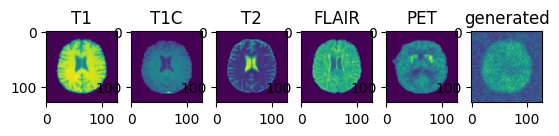

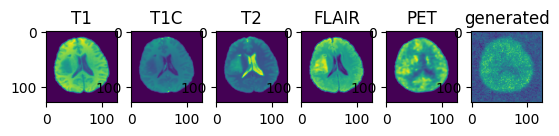

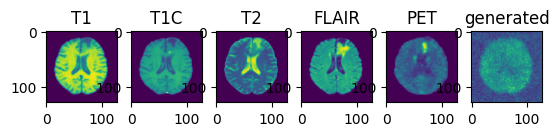

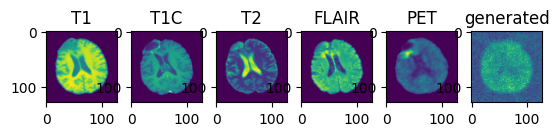

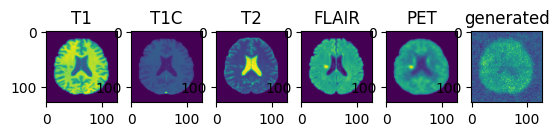

validation avg MS-SSIM: 0.3860 , train avg MS-SSIM: 0.4000
----------
epoch 151/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:15<13:48, 75.36s/it]

Epoch :  17%|██████                              | 2/12 [01:18<05:29, 32.94s/it]

Epoch :  25%|█████████                           | 3/12 [01:21<02:54, 19.35s/it]

Epoch :  33%|████████████                        | 4/12 [01:24<01:43, 12.96s/it]

Epoch :  42%|███████████████                     | 5/12 [01:28<01:06,  9.43s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:31<00:43,  7.31s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:34<00:29,  5.95s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:37<00:20,  5.07s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:41<00:13,  4.58s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:44<00:08,  4.16s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:47<00:03,  3.86s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:49<00:00,  3.27s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:52<00:00,  9.37s/it]

----------
epoch 152/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:19<14:38, 79.86s/it]

Epoch :  17%|██████                              | 2/12 [01:23<05:47, 34.77s/it]

Epoch :  25%|█████████                           | 3/12 [01:26<03:02, 20.33s/it]

Epoch :  33%|████████████                        | 4/12 [01:29<01:49, 13.71s/it]

Epoch :  42%|███████████████                     | 5/12 [01:32<01:09,  9.91s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:36<00:45,  7.62s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:39<00:30,  6.18s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:42<00:20,  5.22s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:45<00:13,  4.58s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:48<00:08,  4.14s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:52<00:03,  3.85s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:54<00:00,  3.37s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:57<00:00,  9.75s/it]

----------
epoch 153/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:14<13:34, 74.05s/it]

Epoch :  17%|██████                              | 2/12 [01:17<05:23, 32.38s/it]

Epoch :  25%|█████████                           | 3/12 [01:20<02:51, 19.05s/it]

Epoch :  33%|████████████                        | 4/12 [01:23<01:42, 12.79s/it]

Epoch :  42%|███████████████                     | 5/12 [01:26<01:05,  9.33s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:29<00:43,  7.23s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:33<00:30,  6.03s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:36<00:20,  5.12s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:39<00:13,  4.51s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:43<00:08,  4.09s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:46<00:03,  3.81s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:48<00:00,  3.25s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:50<00:00,  9.24s/it]

----------
epoch 154/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:13<13:32, 73.87s/it]

Epoch :  17%|██████                              | 2/12 [01:17<05:22, 32.27s/it]

Epoch :  25%|█████████                           | 3/12 [01:20<02:52, 19.16s/it]

Epoch :  33%|████████████                        | 4/12 [01:23<01:42, 12.86s/it]

Epoch :  42%|███████████████                     | 5/12 [01:26<01:05,  9.37s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:30<00:43,  7.25s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:33<00:29,  5.91s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:36<00:20,  5.03s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:39<00:13,  4.44s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:42<00:08,  4.04s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:46<00:03,  3.87s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:48<00:00,  3.29s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:50<00:00,  9.25s/it]

----------
epoch 155/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:12<13:13, 72.13s/it]

Epoch :  17%|██████                              | 2/12 [01:15<05:15, 31.55s/it]

Epoch :  25%|█████████                           | 3/12 [01:18<02:47, 18.58s/it]

Epoch :  33%|████████████                        | 4/12 [01:21<01:39, 12.49s/it]

Epoch :  42%|███████████████                     | 5/12 [01:24<01:03,  9.13s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:27<00:42,  7.10s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:31<00:29,  5.94s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:34<00:20,  5.05s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:37<00:13,  4.46s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:40<00:08,  4.06s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:44<00:03,  3.79s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:46<00:00,  3.22s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:48<00:00,  9.06s/it]

----------
epoch 156/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:12<13:13, 72.18s/it]

Epoch :  17%|██████                              | 2/12 [01:15<05:15, 31.58s/it]

Epoch :  25%|█████████                           | 3/12 [01:18<02:49, 18.78s/it]

Epoch :  33%|████████████                        | 4/12 [01:22<01:41, 12.63s/it]

Epoch :  42%|███████████████                     | 5/12 [01:25<01:04,  9.21s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:28<00:42,  7.15s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:31<00:29,  5.84s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:34<00:19,  4.99s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:37<00:13,  4.42s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:41<00:08,  4.03s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:44<00:03,  3.86s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:46<00:00,  3.28s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:49<00:00,  9.13s/it]

----------
epoch 157/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:14<13:37, 74.27s/it]

Epoch :  17%|██████                              | 2/12 [01:17<05:24, 32.45s/it]

Epoch :  25%|█████████                           | 3/12 [01:20<02:51, 19.08s/it]

Epoch :  33%|████████████                        | 4/12 [01:23<01:42, 12.80s/it]

Epoch :  42%|███████████████                     | 5/12 [01:26<01:05,  9.33s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:30<00:44,  7.37s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:33<00:30,  6.00s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:36<00:20,  5.10s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:40<00:13,  4.50s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:43<00:08,  4.09s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:46<00:03,  3.82s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:48<00:00,  3.25s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:51<00:00,  9.27s/it]

----------
epoch 158/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:10<12:58, 70.81s/it]

Epoch :  17%|██████                              | 2/12 [01:13<05:10, 31.02s/it]

Epoch :  25%|█████████                           | 3/12 [01:17<02:44, 18.31s/it]

Epoch :  33%|████████████                        | 4/12 [01:20<01:38, 12.34s/it]

Epoch :  42%|███████████████                     | 5/12 [01:23<01:03,  9.03s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:26<00:42,  7.03s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:29<00:28,  5.76s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:32<00:19,  4.93s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:36<00:13,  4.38s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:39<00:08,  4.11s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:42<00:03,  3.82s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:44<00:00,  3.26s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:47<00:00,  8.94s/it]

----------
epoch 159/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:10<13:00, 70.95s/it]

Epoch :  17%|██████                              | 2/12 [01:14<05:11, 31.11s/it]

Epoch :  25%|█████████                           | 3/12 [01:17<02:45, 18.36s/it]

Epoch :  33%|████████████                        | 4/12 [01:20<01:38, 12.36s/it]

Epoch :  42%|███████████████                     | 5/12 [01:23<01:03,  9.04s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:27<00:43,  7.17s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:30<00:29,  5.86s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:33<00:20,  5.01s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:36<00:13,  4.43s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:39<00:08,  4.05s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:43<00:03,  3.78s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:45<00:00,  3.22s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:48<00:00,  9.00s/it]

----------
epoch 160/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:10<13:00, 70.93s/it]

Epoch :  17%|██████                              | 2/12 [01:14<05:10, 31.08s/it]

Epoch :  25%|█████████                           | 3/12 [01:17<02:45, 18.34s/it]

Epoch :  33%|████████████                        | 4/12 [01:20<01:38, 12.36s/it]

Epoch :  42%|███████████████                     | 5/12 [01:23<01:03,  9.05s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:26<00:42,  7.05s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:29<00:28,  5.78s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:33<00:19,  4.95s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:36<00:13,  4.39s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:39<00:08,  4.01s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:42<00:03,  3.75s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:44<00:00,  3.21s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:47<00:00,  8.94s/it]

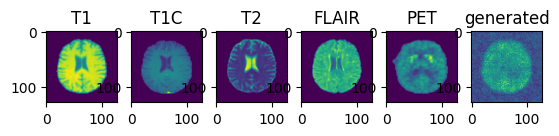

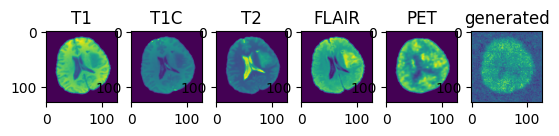

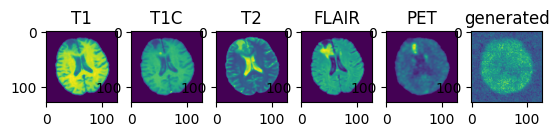

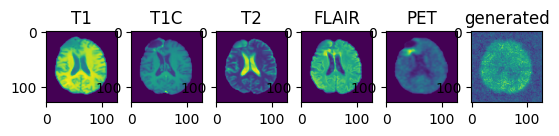

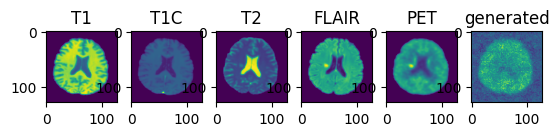

validation avg MS-SSIM: 0.3888 , train avg MS-SSIM: 0.4005
----------
epoch 161/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:13<13:28, 73.48s/it]

Epoch :  17%|██████                              | 2/12 [01:17<05:24, 32.44s/it]

Epoch :  25%|█████████                           | 3/12 [01:20<02:51, 19.10s/it]

Epoch :  33%|████████████                        | 4/12 [01:23<01:42, 12.83s/it]

Epoch :  42%|███████████████                     | 5/12 [01:26<01:05,  9.37s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:30<00:43,  7.27s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:33<00:29,  5.95s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:36<00:20,  5.09s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:40<00:14,  4.77s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:43<00:08,  4.28s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:47<00:03,  3.95s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:48<00:00,  3.35s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:51<00:00,  9.31s/it]

----------
epoch 162/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:09<12:48, 69.88s/it]

Epoch :  17%|██████                              | 2/12 [01:13<05:06, 30.65s/it]

Epoch :  25%|█████████                           | 3/12 [01:16<02:42, 18.10s/it]

Epoch :  33%|████████████                        | 4/12 [01:19<01:37, 12.22s/it]

Epoch :  42%|███████████████                     | 5/12 [01:22<01:03,  9.10s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:26<00:42,  7.07s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:29<00:28,  5.79s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:32<00:19,  4.95s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:35<00:13,  4.39s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:38<00:08,  4.02s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:41<00:03,  3.76s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:43<00:00,  3.20s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:46<00:00,  8.89s/it]

----------
epoch 163/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:12<13:19, 72.71s/it]

Epoch :  17%|██████                              | 2/12 [01:15<05:17, 31.80s/it]

Epoch :  25%|█████████                           | 3/12 [01:19<02:48, 18.72s/it]

Epoch :  33%|████████████                        | 4/12 [01:22<01:40, 12.59s/it]

Epoch :  42%|███████████████                     | 5/12 [01:25<01:04,  9.19s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:28<00:42,  7.14s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:31<00:29,  5.83s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:34<00:19,  4.98s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:37<00:13,  4.41s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:41<00:08,  4.02s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:44<00:03,  3.76s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:46<00:00,  3.21s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:49<00:00,  9.11s/it]

----------
epoch 164/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:11<13:05, 71.39s/it]

Epoch :  17%|██████                              | 2/12 [01:14<05:12, 31.26s/it]

Epoch :  25%|█████████                           | 3/12 [01:17<02:45, 18.43s/it]

Epoch :  33%|████████████                        | 4/12 [01:20<01:39, 12.41s/it]

Epoch :  42%|███████████████                     | 5/12 [01:24<01:04,  9.20s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:27<00:42,  7.14s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:30<00:29,  5.84s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:33<00:19,  4.99s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:37<00:13,  4.41s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:40<00:08,  4.03s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:43<00:03,  3.77s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:45<00:00,  3.22s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:48<00:00,  9.02s/it]

----------
epoch 165/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:08<12:33, 68.53s/it]

Epoch :  17%|██████                              | 2/12 [01:11<05:00, 30.08s/it]

Epoch :  25%|█████████                           | 3/12 [01:14<02:40, 17.80s/it]

Epoch :  33%|████████████                        | 4/12 [01:18<01:36, 12.02s/it]

Epoch :  42%|███████████████                     | 5/12 [01:21<01:01,  8.83s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:24<00:41,  6.90s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:27<00:28,  5.68s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:31<00:19,  4.99s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:34<00:13,  4.42s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:37<00:08,  4.03s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:40<00:03,  3.77s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:42<00:00,  3.21s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:45<00:00,  8.76s/it]

----------
epoch 166/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:13<13:32, 73.87s/it]

Epoch :  17%|██████                              | 2/12 [01:17<05:22, 32.28s/it]

Epoch :  25%|█████████                           | 3/12 [01:20<02:51, 19.00s/it]

Epoch :  33%|████████████                        | 4/12 [01:23<01:43, 12.97s/it]

Epoch :  42%|███████████████                     | 5/12 [01:27<01:06,  9.45s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:30<00:43,  7.31s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:33<00:29,  5.97s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:36<00:20,  5.08s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:39<00:13,  4.48s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:43<00:08,  4.08s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:46<00:03,  3.80s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:48<00:00,  3.33s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:51<00:00,  9.27s/it]

----------
epoch 167/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:15<13:46, 75.15s/it]

Epoch :  17%|██████                              | 2/12 [01:18<05:28, 32.80s/it]

Epoch :  25%|█████████                           | 3/12 [01:21<02:53, 19.27s/it]

Epoch :  33%|████████████                        | 4/12 [01:24<01:43, 12.91s/it]

Epoch :  42%|███████████████                     | 5/12 [01:27<01:05,  9.39s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:30<00:43,  7.27s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:34<00:29,  5.92s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:37<00:20,  5.17s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:40<00:13,  4.55s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:43<00:08,  4.12s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:47<00:03,  3.82s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:49<00:00,  3.25s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:51<00:00,  9.33s/it]

----------
epoch 168/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:09<12:39, 69.03s/it]

Epoch :  17%|██████                              | 2/12 [01:12<05:02, 30.28s/it]

Epoch :  25%|█████████                           | 3/12 [01:15<02:42, 18.09s/it]

Epoch :  33%|████████████                        | 4/12 [01:18<01:37, 12.19s/it]

Epoch :  42%|███████████████                     | 5/12 [01:22<01:02,  8.93s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:25<00:41,  6.96s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:28<00:28,  5.71s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:31<00:19,  4.90s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:34<00:13,  4.36s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:37<00:07,  3.99s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:41<00:03,  3.83s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:43<00:00,  3.26s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:45<00:00,  8.83s/it]

----------
epoch 169/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:12<13:14, 72.22s/it]

Epoch :  17%|██████                              | 2/12 [01:15<05:15, 31.59s/it]

Epoch :  25%|█████████                           | 3/12 [01:18<02:47, 18.61s/it]

Epoch :  33%|████████████                        | 4/12 [01:21<01:40, 12.51s/it]

Epoch :  42%|███████████████                     | 5/12 [01:24<01:04,  9.15s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:28<00:42,  7.12s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:31<00:29,  5.95s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:34<00:20,  5.07s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:37<00:13,  4.47s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:41<00:08,  4.07s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:44<00:03,  3.79s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:46<00:00,  3.24s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:48<00:00,  9.07s/it]

----------
epoch 170/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:11<13:06, 71.52s/it]

Epoch :  17%|██████                              | 2/12 [01:14<05:13, 31.31s/it]

Epoch :  25%|█████████                           | 3/12 [01:18<02:47, 18.62s/it]

Epoch :  33%|████████████                        | 4/12 [01:21<01:40, 12.51s/it]

Epoch :  42%|███████████████                     | 5/12 [01:24<01:03,  9.14s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:27<00:42,  7.10s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:30<00:29,  5.81s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:33<00:19,  4.98s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:37<00:13,  4.41s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:40<00:08,  4.03s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:43<00:03,  3.85s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:45<00:00,  3.27s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:48<00:00,  9.02s/it]

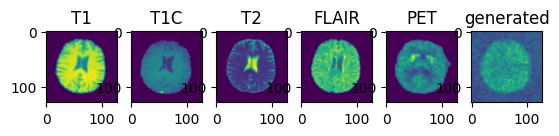

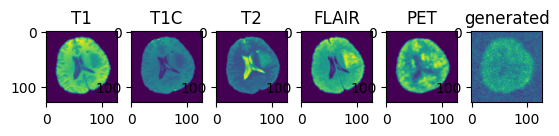

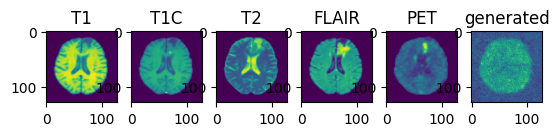

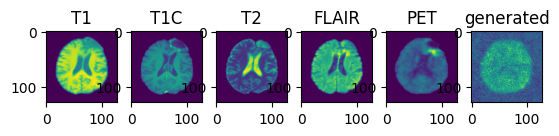

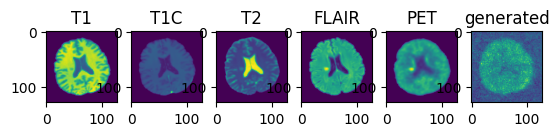

validation avg MS-SSIM: 0.3823 , train avg MS-SSIM: 0.4025
----------
epoch 171/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:13<13:33, 73.99s/it]

Epoch :  17%|██████                              | 2/12 [01:17<05:23, 32.34s/it]

Epoch :  25%|█████████                           | 3/12 [01:20<02:51, 19.02s/it]

Epoch :  33%|████████████                        | 4/12 [01:24<01:43, 12.97s/it]

Epoch :  42%|███████████████                     | 5/12 [01:27<01:06,  9.43s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:30<00:43,  7.30s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:33<00:29,  5.94s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:36<00:20,  5.06s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:39<00:13,  4.46s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:42<00:08,  4.06s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:46<00:03,  3.78s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:48<00:00,  3.33s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:51<00:00,  9.27s/it]

----------
epoch 172/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:10<12:56, 70.57s/it]

Epoch :  17%|██████                              | 2/12 [01:13<05:09, 30.96s/it]

Epoch :  25%|█████████                           | 3/12 [01:17<02:44, 18.29s/it]

Epoch :  33%|████████████                        | 4/12 [01:20<01:38, 12.33s/it]

Epoch :  42%|███████████████                     | 5/12 [01:23<01:03,  9.03s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:26<00:42,  7.04s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:29<00:28,  5.79s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:33<00:20,  5.07s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:36<00:13,  4.48s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:39<00:08,  4.07s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:42<00:03,  3.80s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:44<00:00,  3.25s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:47<00:00,  8.96s/it]

----------
epoch 173/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:09<12:48, 69.82s/it]

Epoch :  17%|██████                              | 2/12 [01:12<05:06, 30.61s/it]

Epoch :  25%|█████████                           | 3/12 [01:16<02:42, 18.08s/it]

Epoch :  33%|████████████                        | 4/12 [01:19<01:38, 12.33s/it]

Epoch :  42%|███████████████                     | 5/12 [01:22<01:03,  9.02s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:25<00:42,  7.02s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:29<00:28,  5.76s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:32<00:19,  4.93s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:35<00:13,  4.37s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:38<00:07,  4.00s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:42<00:03,  3.85s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:44<00:00,  3.28s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:46<00:00,  8.89s/it]

----------
epoch 174/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:11<13:05, 71.43s/it]

Epoch :  17%|██████                              | 2/12 [01:14<05:12, 31.28s/it]

Epoch :  25%|█████████                           | 3/12 [01:17<02:46, 18.45s/it]

Epoch :  33%|████████████                        | 4/12 [01:20<01:39, 12.41s/it]

Epoch :  42%|███████████████                     | 5/12 [01:24<01:03,  9.08s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:27<00:42,  7.06s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:30<00:29,  5.90s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:33<00:20,  5.03s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:37<00:13,  4.45s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:40<00:08,  4.06s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:43<00:03,  3.78s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:45<00:00,  3.22s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:47<00:00,  8.99s/it]

----------
epoch 175/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:10<12:56, 70.60s/it]

Epoch :  17%|██████                              | 2/12 [01:14<05:11, 31.12s/it]

Epoch :  25%|█████████                           | 3/12 [01:17<02:45, 18.35s/it]

Epoch :  33%|████████████                        | 4/12 [01:20<01:38, 12.36s/it]

Epoch :  42%|███████████████                     | 5/12 [01:23<01:03,  9.04s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:26<00:42,  7.04s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:29<00:28,  5.77s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:33<00:19,  4.93s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:36<00:13,  4.37s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:39<00:08,  4.10s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:42<00:03,  3.81s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:44<00:00,  3.24s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:47<00:00,  8.93s/it]

----------
epoch 176/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:12<13:18, 72.64s/it]

Epoch :  17%|██████                              | 2/12 [01:15<05:17, 31.77s/it]

Epoch :  25%|█████████                           | 3/12 [01:18<02:48, 18.70s/it]

Epoch :  33%|████████████                        | 4/12 [01:22<01:40, 12.56s/it]

Epoch :  42%|███████████████                     | 5/12 [01:25<01:04,  9.18s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:28<00:43,  7.27s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:32<00:29,  5.93s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:35<00:20,  5.06s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:38<00:13,  4.46s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:41<00:08,  4.06s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:44<00:03,  3.78s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:46<00:00,  3.23s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:49<00:00,  9.14s/it]

----------
epoch 177/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:11<13:05, 71.42s/it]

Epoch :  17%|██████                              | 2/12 [01:15<05:15, 31.55s/it]

Epoch :  25%|█████████                           | 3/12 [01:18<02:47, 18.58s/it]

Epoch :  33%|████████████                        | 4/12 [01:21<01:39, 12.50s/it]

Epoch :  42%|███████████████                     | 5/12 [01:24<01:03,  9.13s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:27<00:42,  7.11s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:30<00:29,  5.81s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:34<00:19,  4.97s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:37<00:13,  4.49s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:40<00:08,  4.08s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:43<00:03,  3.80s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:45<00:00,  3.24s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:48<00:00,  9.02s/it]

----------
epoch 178/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:12<13:16, 72.37s/it]

Epoch :  17%|██████                              | 2/12 [01:15<05:16, 31.67s/it]

Epoch :  25%|█████████                           | 3/12 [01:18<02:47, 18.66s/it]

Epoch :  33%|████████████                        | 4/12 [01:21<01:40, 12.54s/it]

Epoch :  42%|███████████████                     | 5/12 [01:25<01:05,  9.31s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:28<00:43,  7.22s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:31<00:29,  5.89s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:34<00:20,  5.02s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:38<00:13,  4.44s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:41<00:08,  4.04s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:44<00:03,  3.78s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:46<00:00,  3.22s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:48<00:00,  9.07s/it]

----------
epoch 179/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:11<13:03, 71.20s/it]

Epoch :  17%|██████                              | 2/12 [01:14<05:12, 31.22s/it]

Epoch :  25%|█████████                           | 3/12 [01:17<02:45, 18.42s/it]

Epoch :  33%|████████████                        | 4/12 [01:20<01:39, 12.41s/it]

Epoch :  42%|███████████████                     | 5/12 [01:24<01:03,  9.09s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:27<00:42,  7.08s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:30<00:29,  5.80s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:33<00:19,  4.96s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:37<00:13,  4.50s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:40<00:08,  4.09s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:43<00:03,  3.80s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:45<00:00,  3.24s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:47<00:00,  8.98s/it]

----------
epoch 180/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:11<13:03, 71.26s/it]

Epoch :  17%|██████                              | 2/12 [01:14<05:11, 31.20s/it]

Epoch :  25%|█████████                           | 3/12 [01:17<02:45, 18.39s/it]

Epoch :  33%|████████████                        | 4/12 [01:20<01:38, 12.37s/it]

Epoch :  42%|███████████████                     | 5/12 [01:24<01:04,  9.19s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:27<00:42,  7.14s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:30<00:29,  5.84s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:33<00:19,  4.98s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:36<00:13,  4.41s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:40<00:08,  4.02s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:43<00:03,  3.76s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:45<00:00,  3.20s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:47<00:00,  9.00s/it]

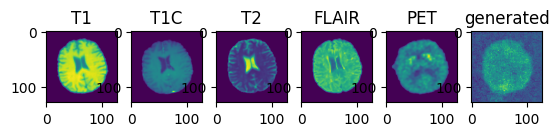

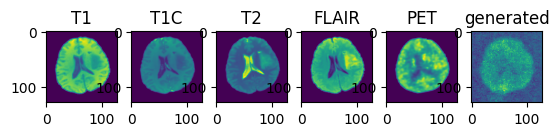

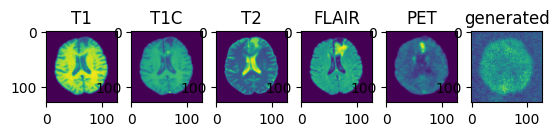

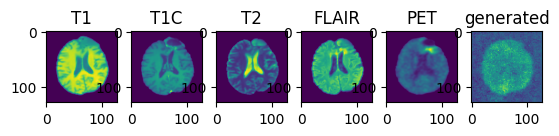

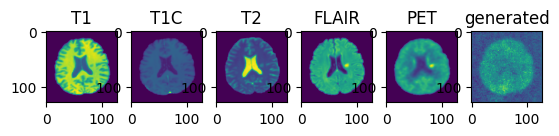

validation avg MS-SSIM: 0.3923 , train avg MS-SSIM: 0.4088
----------
epoch 181/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:12<13:12, 72.08s/it]

Epoch :  17%|██████                              | 2/12 [01:15<05:15, 31.53s/it]

Epoch :  25%|█████████                           | 3/12 [01:18<02:47, 18.58s/it]

Epoch :  33%|████████████                        | 4/12 [01:21<01:39, 12.49s/it]

Epoch :  42%|███████████████                     | 5/12 [01:24<01:03,  9.12s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:28<00:43,  7.24s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:31<00:29,  5.90s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:34<00:20,  5.03s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:37<00:13,  4.44s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:40<00:08,  4.04s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:44<00:03,  3.77s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:45<00:00,  3.21s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:48<00:00,  9.05s/it]

----------
epoch 182/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:11<13:09, 71.75s/it]

Epoch :  17%|██████                              | 2/12 [01:15<05:16, 31.66s/it]

Epoch :  25%|█████████                           | 3/12 [01:18<02:47, 18.66s/it]

Epoch :  33%|████████████                        | 4/12 [01:21<01:40, 12.54s/it]

Epoch :  42%|███████████████                     | 5/12 [01:24<01:04,  9.16s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:28<00:42,  7.12s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:31<00:29,  5.83s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:34<00:19,  4.98s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:37<00:13,  4.51s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:41<00:08,  4.10s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:44<00:03,  3.81s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:46<00:00,  3.25s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:49<00:00,  9.08s/it]

----------
epoch 183/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:12<13:19, 72.69s/it]

Epoch :  17%|██████                              | 2/12 [01:15<05:18, 31.81s/it]

Epoch :  25%|█████████                           | 3/12 [01:19<02:48, 18.76s/it]

Epoch :  33%|████████████                        | 4/12 [01:22<01:42, 12.78s/it]

Epoch :  42%|███████████████                     | 5/12 [01:25<01:05,  9.31s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:29<00:43,  7.22s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:32<00:29,  5.90s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:35<00:20,  5.03s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:38<00:13,  4.45s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:41<00:08,  4.05s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:44<00:03,  3.77s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:47<00:00,  3.31s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:49<00:00,  9.15s/it]

----------
epoch 184/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:11<13:08, 71.64s/it]

Epoch :  17%|██████                              | 2/12 [01:14<05:13, 31.36s/it]

Epoch :  25%|█████████                           | 3/12 [01:17<02:46, 18.49s/it]

Epoch :  33%|████████████                        | 4/12 [01:21<01:39, 12.44s/it]

Epoch :  42%|███████████████                     | 5/12 [01:24<01:03,  9.10s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:27<00:42,  7.08s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:30<00:29,  5.80s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:34<00:20,  5.07s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:37<00:13,  4.48s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:40<00:08,  4.07s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:43<00:03,  3.79s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:45<00:00,  3.24s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:48<00:00,  9.03s/it]

----------
epoch 185/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:11<13:06, 71.47s/it]

Epoch :  17%|██████                              | 2/12 [01:14<05:12, 31.29s/it]

Epoch :  25%|█████████                           | 3/12 [01:18<02:47, 18.62s/it]

Epoch :  33%|████████████                        | 4/12 [01:21<01:40, 12.52s/it]

Epoch :  42%|███████████████                     | 5/12 [01:24<01:03,  9.14s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:27<00:42,  7.11s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:30<00:29,  5.82s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:33<00:19,  4.97s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:37<00:13,  4.40s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:40<00:08,  4.01s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:43<00:03,  3.84s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:45<00:00,  3.27s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:48<00:00,  9.01s/it]

----------
epoch 186/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:12<13:21, 72.86s/it]

Epoch :  17%|██████                              | 2/12 [01:16<05:18, 31.86s/it]

Epoch :  25%|█████████                           | 3/12 [01:19<02:48, 18.76s/it]

Epoch :  33%|████████████                        | 4/12 [01:22<01:40, 12.60s/it]

Epoch :  42%|███████████████                     | 5/12 [01:25<01:04,  9.20s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:29<00:43,  7.29s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:32<00:29,  5.95s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:35<00:20,  5.06s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:38<00:13,  4.47s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:41<00:08,  4.06s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:44<00:03,  3.79s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:46<00:00,  3.23s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:49<00:00,  9.16s/it]

----------
epoch 187/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:11<13:03, 71.21s/it]

Epoch :  17%|██████                              | 2/12 [01:14<05:14, 31.41s/it]

Epoch :  25%|█████████                           | 3/12 [01:17<02:46, 18.53s/it]

Epoch :  33%|████████████                        | 4/12 [01:21<01:39, 12.48s/it]

Epoch :  42%|███████████████                     | 5/12 [01:24<01:03,  9.11s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:27<00:42,  7.09s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:30<00:28,  5.80s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:33<00:19,  4.96s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:36<00:13,  4.40s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:40<00:08,  4.11s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:43<00:03,  3.82s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:45<00:00,  3.24s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:48<00:00,  9.01s/it]

----------
epoch 188/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:10<12:54, 70.44s/it]

Epoch :  17%|██████                              | 2/12 [01:13<05:08, 30.89s/it]

Epoch :  25%|█████████                           | 3/12 [01:16<02:44, 18.24s/it]

Epoch :  33%|████████████                        | 4/12 [01:20<01:38, 12.29s/it]

Epoch :  42%|███████████████                     | 5/12 [01:23<01:04,  9.15s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:26<00:42,  7.12s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:29<00:29,  5.83s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:33<00:19,  4.99s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:36<00:13,  4.42s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:39<00:08,  4.03s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:42<00:03,  3.77s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:44<00:00,  3.22s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:47<00:00,  8.94s/it]

----------
epoch 189/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:12<13:21, 72.86s/it]

Epoch :  17%|██████                              | 2/12 [01:16<05:18, 31.86s/it]

Epoch :  25%|█████████                           | 3/12 [01:19<02:48, 18.76s/it]

Epoch :  33%|████████████                        | 4/12 [01:22<01:40, 12.59s/it]

Epoch :  42%|███████████████                     | 5/12 [01:25<01:04,  9.20s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:28<00:42,  7.15s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:31<00:29,  5.84s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:35<00:20,  5.09s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:38<00:13,  4.48s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:41<00:08,  4.07s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:44<00:03,  3.79s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:46<00:00,  3.23s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:49<00:00,  9.14s/it]

----------
epoch 190/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:11<13:04, 71.31s/it]

Epoch :  17%|██████                              | 2/12 [01:14<05:12, 31.23s/it]

Epoch :  25%|█████████                           | 3/12 [01:17<02:45, 18.41s/it]

Epoch :  33%|████████████                        | 4/12 [01:21<01:40, 12.53s/it]

Epoch :  42%|███████████████                     | 5/12 [01:24<01:04,  9.15s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:27<00:42,  7.11s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:30<00:29,  5.82s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:33<00:19,  4.97s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:36<00:13,  4.41s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:40<00:08,  4.02s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:43<00:03,  3.76s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:45<00:00,  3.31s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:48<00:00,  9.02s/it]

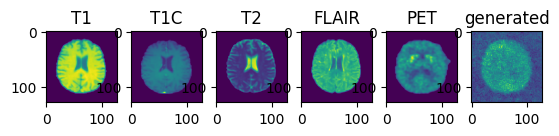

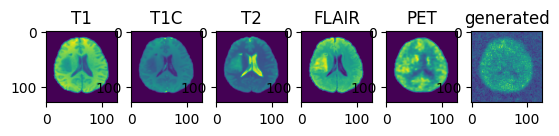

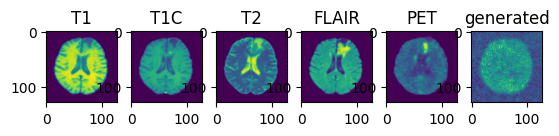

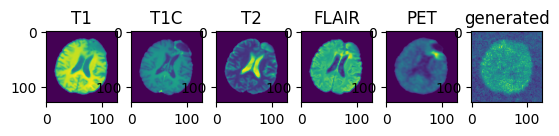

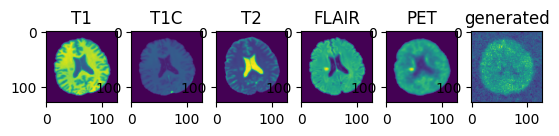

validation avg MS-SSIM: 0.3848 , train avg MS-SSIM: 0.4019
----------
epoch 191/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:10<12:59, 70.88s/it]

Epoch :  17%|██████                              | 2/12 [01:14<05:10, 31.06s/it]

Epoch :  25%|█████████                           | 3/12 [01:17<02:44, 18.31s/it]

Epoch :  33%|████████████                        | 4/12 [01:20<01:38, 12.33s/it]

Epoch :  42%|███████████████                     | 5/12 [01:23<01:03,  9.02s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:27<00:43,  7.18s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:30<00:29,  5.87s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:33<00:20,  5.01s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:36<00:13,  4.43s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:39<00:08,  4.03s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:42<00:03,  3.77s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:44<00:00,  3.22s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:47<00:00,  8.98s/it]

----------
epoch 192/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:12<13:12, 72.04s/it]

Epoch :  17%|██████                              | 2/12 [01:15<05:15, 31.56s/it]

Epoch :  25%|█████████                           | 3/12 [01:18<02:47, 18.60s/it]

Epoch :  33%|████████████                        | 4/12 [01:21<01:40, 12.52s/it]

Epoch :  42%|███████████████                     | 5/12 [01:24<01:04,  9.15s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:27<00:42,  7.12s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:31<00:29,  5.84s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:34<00:19,  5.00s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:37<00:13,  4.43s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:41<00:08,  4.15s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:44<00:03,  3.86s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:46<00:00,  3.29s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:48<00:00,  9.07s/it]

----------
epoch 193/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:11<13:10, 71.88s/it]

Epoch :  17%|██████                              | 2/12 [01:15<05:14, 31.46s/it]

Epoch :  25%|█████████                           | 3/12 [01:18<02:46, 18.54s/it]

Epoch :  33%|████████████                        | 4/12 [01:21<01:39, 12.48s/it]

Epoch :  42%|███████████████                     | 5/12 [01:24<01:04,  9.26s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:28<00:43,  7.19s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:31<00:29,  5.87s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:34<00:20,  5.01s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:37<00:13,  4.44s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:40<00:08,  4.05s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:43<00:03,  3.78s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:45<00:00,  3.23s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:49<00:00,  9.09s/it]

----------
epoch 194/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:10<13:00, 70.92s/it]

Epoch :  17%|██████                              | 2/12 [01:14<05:10, 31.06s/it]

Epoch :  25%|█████████                           | 3/12 [01:17<02:44, 18.32s/it]

Epoch :  33%|████████████                        | 4/12 [01:20<01:38, 12.33s/it]

Epoch :  42%|███████████████                     | 5/12 [01:23<01:03,  9.02s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:26<00:42,  7.03s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:29<00:28,  5.76s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:33<00:19,  4.93s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:36<00:13,  4.38s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:39<00:08,  4.09s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:42<00:03,  3.81s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:44<00:00,  3.23s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:48<00:00,  9.01s/it]

----------
epoch 195/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:15<13:53, 75.79s/it]

Epoch :  17%|██████                              | 2/12 [01:19<05:30, 33.10s/it]

Epoch :  25%|█████████                           | 3/12 [01:22<02:54, 19.44s/it]

Epoch :  33%|████████████                        | 4/12 [01:25<01:44, 13.02s/it]

Epoch :  42%|███████████████                     | 5/12 [01:28<01:06,  9.46s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:31<00:43,  7.33s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:34<00:29,  5.97s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:38<00:20,  5.08s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:41<00:13,  4.49s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:44<00:08,  4.08s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:47<00:03,  3.81s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:49<00:00,  3.24s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:52<00:00,  9.38s/it]

----------
epoch 196/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:11<13:05, 71.38s/it]

Epoch :  17%|██████                              | 2/12 [01:14<05:12, 31.26s/it]

Epoch :  25%|█████████                           | 3/12 [01:17<02:45, 18.44s/it]

Epoch :  33%|████████████                        | 4/12 [01:20<01:39, 12.40s/it]

Epoch :  42%|███████████████                     | 5/12 [01:24<01:03,  9.07s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:27<00:42,  7.06s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:30<00:28,  5.78s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:33<00:19,  4.94s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:36<00:13,  4.48s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:40<00:08,  4.07s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:43<00:03,  3.79s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:45<00:00,  3.23s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:48<00:00,  9.01s/it]

----------
epoch 197/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:12<13:21, 72.89s/it]

Epoch :  17%|██████                              | 2/12 [01:16<05:18, 31.87s/it]

Epoch :  25%|█████████                           | 3/12 [01:19<02:48, 18.77s/it]

Epoch :  33%|████████████                        | 4/12 [01:22<01:42, 12.75s/it]

Epoch :  42%|███████████████                     | 5/12 [01:25<01:05,  9.30s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:29<00:43,  7.21s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:32<00:29,  5.89s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:35<00:20,  5.02s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:38<00:13,  4.44s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:41<00:08,  4.04s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:44<00:03,  3.77s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:47<00:00,  3.31s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:50<00:00,  9.17s/it]

----------
epoch 198/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:10<12:59, 70.85s/it]

Epoch :  17%|██████                              | 2/12 [01:14<05:10, 31.08s/it]

Epoch :  25%|█████████                           | 3/12 [01:17<02:45, 18.33s/it]

Epoch :  33%|████████████                        | 4/12 [01:20<01:38, 12.34s/it]

Epoch :  42%|███████████████                     | 5/12 [01:23<01:03,  9.03s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:26<00:42,  7.03s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:29<00:28,  5.77s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:33<00:20,  5.05s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:36<00:13,  4.45s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:39<00:08,  4.06s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:42<00:03,  3.78s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:44<00:00,  3.23s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:47<00:00,  8.95s/it]

----------
epoch 199/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:13<13:24, 73.10s/it]

Epoch :  17%|██████                              | 2/12 [01:16<05:20, 32.03s/it]

Epoch :  25%|█████████                           | 3/12 [01:19<02:49, 18.87s/it]

Epoch :  33%|████████████                        | 4/12 [01:23<01:42, 12.84s/it]

Epoch :  42%|███████████████                     | 5/12 [01:26<01:05,  9.37s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:29<00:43,  7.26s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:32<00:29,  5.92s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:35<00:20,  5.04s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:39<00:13,  4.45s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:42<00:08,  4.05s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:45<00:03,  3.77s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:47<00:00,  3.32s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:49<00:00,  9.16s/it]

----------
epoch 200/200


Epoch :   0%|                                            | 0/12 [00:00<?, ?it/s]

Epoch :   8%|███                                 | 1/12 [01:13<13:26, 73.30s/it]

Epoch :  17%|██████                              | 2/12 [01:16<05:20, 32.02s/it]

Epoch :  25%|█████████                           | 3/12 [01:19<02:50, 18.92s/it]

Epoch :  33%|████████████                        | 4/12 [01:23<01:41, 12.74s/it]

Epoch :  42%|███████████████                     | 5/12 [01:26<01:05,  9.30s/it]

Epoch :  50%|██████████████████                  | 6/12 [01:29<00:43,  7.22s/it]

Epoch :  58%|█████████████████████               | 7/12 [01:32<00:29,  5.91s/it]

Epoch :  67%|████████████████████████            | 8/12 [01:36<00:20,  5.19s/it]

Epoch :  75%|███████████████████████████         | 9/12 [01:39<00:13,  4.57s/it]

Epoch :  83%|█████████████████████████████▏     | 10/12 [01:42<00:08,  4.15s/it]

Epoch :  92%|████████████████████████████████   | 11/12 [01:45<00:03,  3.86s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:47<00:00,  3.29s/it]

Epoch : 100%|███████████████████████████████████| 12/12 [01:50<00:00,  9.19s/it]

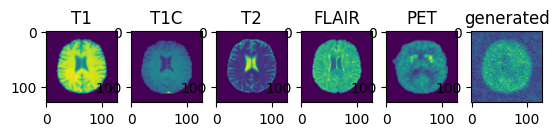

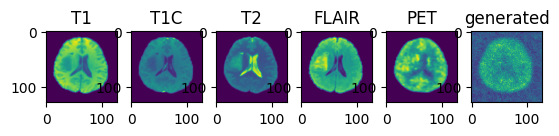

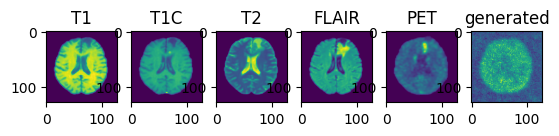

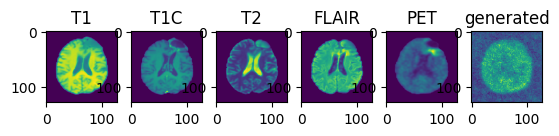

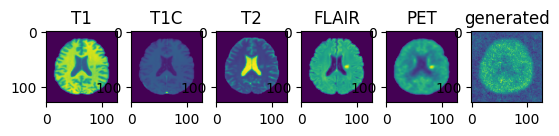

validation avg MS-SSIM: 0.3784 , train avg MS-SSIM: 0.3947


In [12]:
epoch_loss_values = [(0, 0)]
gen_step_loss = []
disc_step_loss = []
step = 0
max_epochs = 200
disc_train_interval = 1
disc_train_steps = 3
validation_interval = 10
best_ssim = 0.36
torch.cuda.empty_cache()

saved_dict = torch.load("experiment8.pth")
gen_net.load_state_dict(saved_dict['model_state_dict'])

for epoch in range(max_epochs):
    
    gen_net.train()
    disc_net.train()
    epoch_loss = 0

    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")

    for batch_data in tqdm(train_loader, desc=("Epoch ")):
        input_images = torch.cat((batch_data["t1"].to(device, dtype=torch.float), 
                                 batch_data["t1c"].to(device, dtype=torch.float), 
                                 batch_data["t2"].to(device, dtype=torch.float), 
                                 batch_data["flair"].to(device, dtype=torch.float)), dim=1).to(device)

        real_pet = batch_data["pet"].to(device, dtype=torch.float)
        
        gen_images = gen_net(input_images)
        gen_opt.zero_grad()
        loss = generator_loss(gen_images, real_pet)
        loss.backward()
        gen_opt.step()
        epoch_loss += loss.item()
        
        real_pet = real_pet[:,0,:,:,:]
        gen_images = gen_images[:,0,:,:,:]

        gen_step_loss.append((step, loss.item()))

        if step % disc_train_interval == 0:
            disc_total_loss = 0

            for _ in range(disc_train_steps):
                disc_opt.zero_grad()
                dloss = discriminator_loss(gen_images, real_pet)
                dloss.backward()
                disc_opt.step()
                disc_total_loss += dloss.item()

            disc_step_loss.append((step, disc_total_loss / disc_train_steps))
        step += 1
    
    epoch_loss /= step
    epoch_loss_values.append((step, epoch_loss))

    if (epoch+1) % validation_interval == 0:
        gen_net.eval()
        slice_index = 32
        ms_ssim = []
        ms_ssim_train = []
        ms_ssim_function = monai.metrics.MultiScaleSSIMMetric(spatial_dims = 3, reduction="none", kernel_size=4)
        
        with torch.no_grad():

            for item in train_metric_loader:
                input_images = torch.cat((item["t1"].to(device, dtype=torch.float), 
                                     item["t1c"].to(device, dtype=torch.float), 
                                     item["t2"].to(device, dtype=torch.float), 
                                     item["flair"].to(device, dtype=torch.float)), dim=1).to(device)
                
                generated = gen_net(input_images)
                ms_ssim_train.append(ms_ssim_function(generated.to(device), item["pet"].to(device)))

            curr_ssim_train = torch.mean(torch.FloatTensor(ms_ssim_train))
            
            for item in valid_loader:
                input_images = torch.cat((item["t1"].to(device, dtype=torch.float), 
                                     item["t1c"].to(device, dtype=torch.float), 
                                     item["t2"].to(device, dtype=torch.float), 
                                     item["flair"].to(device, dtype=torch.float)), dim=1).to(device)

                generated = gen_net(input_images)
        
                image_datas = item["t1"][0, 0, :, :, slice_index], item["t1c"][0, 0, :, :, slice_index], item["t2"][0, 0, :, :, slice_index], item["flair"][0, 0, :, :, slice_index], item["pet"][0, 0, :, :, slice_index], generated[0, 0, :, :, slice_index] 
                
                f, axarr = plt.subplots(1, 6)

                ms_ssim.append(ms_ssim_function(generated.to(device), item["pet"].to(device)))
                
                axarr[0].imshow(image_datas[0])
                axarr[0].set_title("T1")
                axarr[1].imshow(image_datas[1])
                axarr[1].set_title("T1C")
                axarr[2].imshow(image_datas[2])
                axarr[2].set_title("T2")
                axarr[3].imshow(image_datas[3])
                axarr[3].set_title("FLAIR")
                axarr[4].imshow(image_datas[4])
                axarr[4].set_title("PET")
                axarr[5].imshow(image_datas[5].cpu())
                axarr[5].set_title("generated")
                plt.show()
                
            curr_ssim = torch.mean(torch.FloatTensor(ms_ssim))

            if curr_ssim > best_ssim:
                best_ssim = curr_ssim
                torch.save({
                        'epoch': epoch,
                        'model_state_dict': gen_net.state_dict(),
                        'optimizer_state_dict': gen_opt.state_dict(),
                        }, "best_metric_glagan.pth")
                
        print("validation avg MS-SSIM: {:.4f} , train avg MS-SSIM: {:.4f}".format(curr_ssim, curr_ssim_train))
            

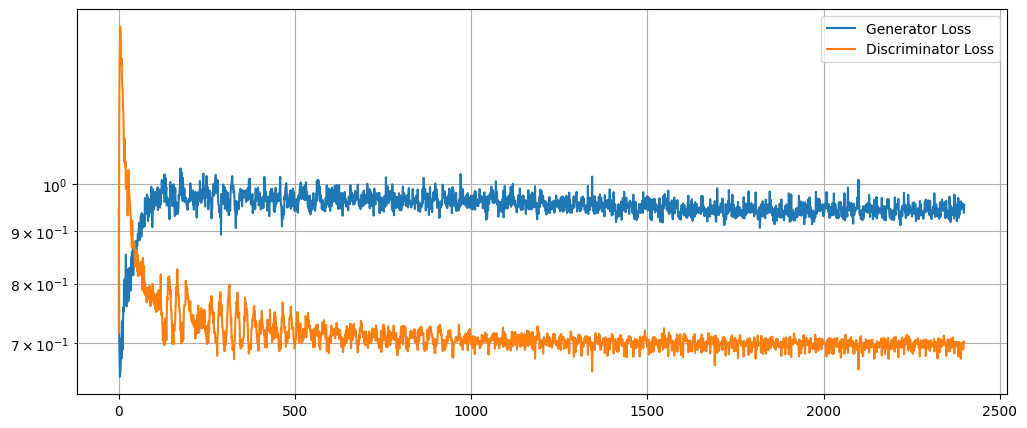

In [13]:
plt.figure(figsize=(12, 5))
plt.semilogy(*zip(*gen_step_loss), label="Generator Loss")
plt.semilogy(*zip(*disc_step_loss), label="Discriminator Loss")
plt.grid(True, "both", "both")
plt.legend()

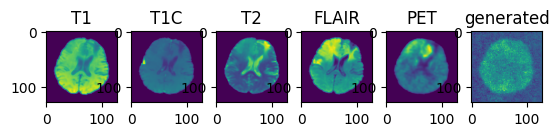

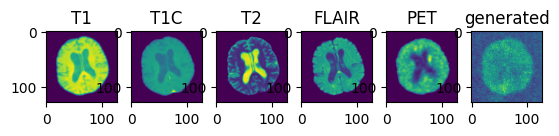

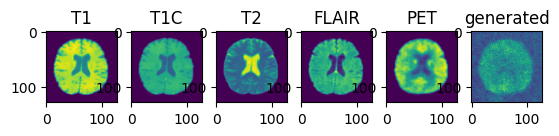

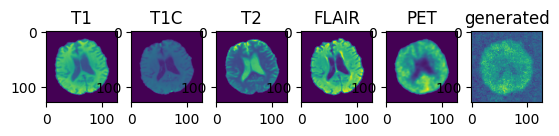

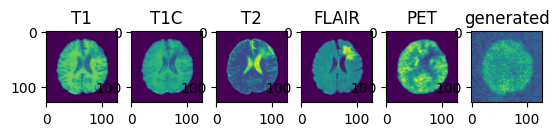

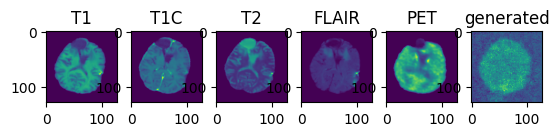

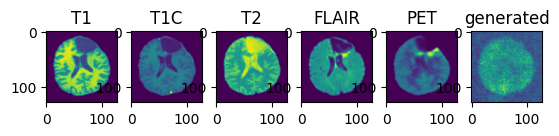

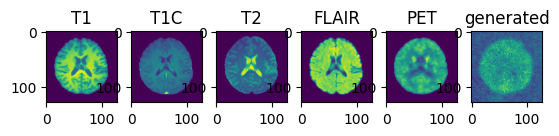

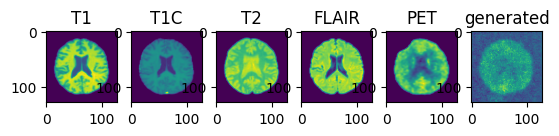

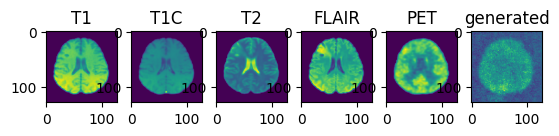

It has been 26917.39110994339 seconds since the loop started
validation avg MS-SSIM: 0.4040 validation avg MSE 0.0000


In [14]:

slice_index = 32

torch.cuda.empty_cache()

saved_dict = torch.load("best_metric_glagan.pth")
gen_net.load_state_dict(saved_dict['model_state_dict'])
gen_net.eval()

ms_ssim = []
ms_ssim_function = monai.metrics.MultiScaleSSIMMetric(spatial_dims = 3, reduction="none", kernel_size=4)

for item in check_DataLoader:

    with torch.no_grad():
        
        input_images = torch.cat((item["t1"].to(device, dtype=torch.float), 
                                     item["t1c"].to(device, dtype=torch.float), 
                                     item["t2"].to(device, dtype=torch.float), 
                                     item["flair"].to(device, dtype=torch.float)), dim=1).to(device)

        generated = gen_net(input_images)
        
        image_datas = item["t1"][0, 0, :, :, slice_index], item["t1c"][0, 0, :, :, slice_index], item["t2"][0, 0, :, :, slice_index], item["flair"][0, 0, :, :, slice_index], item["pet"][0, 0, :, :, slice_index], generated[0, 0, :, :, slice_index] 
                
        f, axarr = plt.subplots(1, 6)

        ms_ssim.append(ms_ssim_function(generated.to(device), item["pet"].to(device)))
                
        axarr[0].imshow(image_datas[0])
        axarr[0].set_title("T1")
        axarr[1].imshow(image_datas[1])
        axarr[1].set_title("T1C")
        axarr[2].imshow(image_datas[2])
        axarr[2].set_title("T2")
        axarr[3].imshow(image_datas[3])
        axarr[3].set_title("FLAIR")
        axarr[4].imshow(image_datas[4])
        axarr[4].set_title("PET")
        axarr[5].imshow(image_datas[5].cpu())
        axarr[5].set_title("generated")
        plt.show()


now = time()
print("It has been {0} seconds since the loop started".format(now - program_starts))

print("validation avg MS-SSIM: {:.4f} validation avg MSE {:.4f}".format(torch.mean(torch.FloatTensor(ms_ssim)), 0))